# ВХОДНЫЕ ДАННЫЕ

In [89]:
K = 0.8
S = 0.65
R = 0.3
xi = [0.70, 0.95, 0.93, 0.89, 0.77, 0.79, 0.91, 0.33, 0.93, 0.71, 0.92, 0.91, 0.43, 0.83, 0.95, 0.73]
file = 'Broneavto_Modern'

## ПРОГРАММА

In [90]:
import matplotlib as mpl
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.optimize as optimize
from matplotlib.pyplot import figure


def input(path):
    path += '.txt'
    DATA_FILEX1 = Path('Data') / path
    with open(DATA_FILEX1, "r") as file:
        X1 = []
        row = file.readlines()
        for i in row :
            t = i.split()
            kostil = []
            for j in t:
                kostil.append(float(j))
            X1.append(kostil)

    X1 = np.array(X1)
    return X1

X0 = input(file)

x = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9]
xs = [0, 0.07, 0.21, 0.36, 0.5, 0.64, 0.79, 0.93]

def v(a):
    t = int(np.size(a)/np.size(a[0]))
    k = int(np.size(a[0])/2)
    b = np.zeros((t,k))
    for i in range(k):
        b[:,i] = a[:,int(2*i)]
    return b


def m(a):
    t = int(np.size(a)/np.size(a[0]))
    k = int(np.size(a[0])/2)
    b = np.zeros((t,k))
    for i in range(k):
        b[:,i] = a[:,int(i)]
    return b

v0 = v(X0)
m0 = m(X0)
experts = int(np.size(v0) / np.size(v0[0]))

def d_niz(i, j):
    return (max(0, m0[i][j] - m0[i][j] * (1 - v0[i][j]) * K))

def d_verh(i, j):
    return (min(1, m0[i][j] + m0[i][j] * (1 - v0[i][j]) * K))

d_niz0 = []
d_verh0 = []
for i in range(experts):
    d_niz0.append([])
    d_verh0.append([])
    for j in range (np.size(v0[0])):
        d_niz0[i].append(d_niz(i, j))
        d_verh0[i].append(d_verh(i, j))
d_niz0 = np.array(d_niz0)
d_verh0 = np.array(d_verh0)

aver_niz0 = []
aver_verh0 = []

def aver(list):
    return np.sum(list) / np.size(list)

for i in range(np.size(v0[0])):
    aver_niz0.append(aver(d_niz0[:,i]))
    aver_verh0.append(aver(d_verh0[:,i]))
    
aver_niz0 = np.array(aver_niz0)
aver_verh0 = np.array(aver_verh0)


inter_integ_niz0 = []
inter_integ_verh0 = []

for i in range(7):
    inter_integ_niz0.append(d_niz0[np.argmin(d_niz0[:,i] - aver_niz0[i])][i])
    inter_integ_verh0.append(d_verh0[np.argmin(d_verh0[:,i] - aver_verh0[i])][i])
    
inter_integ_niz0 = np.array(inter_integ_niz0)
inter_integ_verh0 = np.array(inter_integ_verh0)  


sum = 0
for i in range(7):
    sum += (xs[i + 1] - xs[i]) * inter_integ_niz0[i] / 2
k_gaus_niz0 = 1 / (sum)

sum = 0
for i in range(7):
    sum += (xs[i + 1] - xs[i]) * inter_integ_verh0[i] / 2
k_gaus_verh0 = 1 / sum

def f1(params):
    M, D = params
    sum = 0
    for i in range(7):
        sum += abs(1 / (k_gaus_niz0 * math.sqrt(2 * math.pi * D)) * math.exp( -(xs[i + 1] - M) ** 2 / 2 / D ) - inter_integ_niz0[i])
    return sum

initial_guess = [0, 1]
result = optimize.minimize(f1, initial_guess, bounds=((-10, 10),(0.0000001, 10)))
gaus_params_niz = result.x

def f2(params):
    M, D = params
    sum = 0
    for i in range(7):
        sum += abs(1 / (k_gaus_verh0 * math.sqrt(2 * math.pi * D)) * math.exp( -(xs[i + 1] - M) ** 2 / 2 / D ) - inter_integ_verh0[i])
    return sum

initial_guess = [0, 1]
result = optimize.minimize(f2, initial_guess, bounds=((-10, 10),(0.0000001, 10)))
gaus_params_verh = result.x

gauss_niz0 = []
gauss_verh0 = [] 

def gauss_niz(i, params):
    M, D = params
    return 1 / (k_gaus_niz0 * math.sqrt(2 * math.pi * D)) * math.exp( -(xs[i + 1] - M) ** 2 / 2 / D ) 

def gauss_verh(i, params):
    M, D = params
    return 1 / (k_gaus_verh0 * math.sqrt(2 * math.pi * D)) * math.exp( -(xs[i + 1] - M) ** 2 / 2 / D ) 

for i in range(7):
    gauss_niz0.append(gauss_niz(i, gaus_params_niz))
    gauss_verh0.append(gauss_verh(i, gaus_params_verh))
    
    
    
def func_qual(j):
    sum = 0
    for i in range(7):
        sum += max(m0[j][i] - gauss_niz0[i], m0[j][i] - gauss_verh0[i])
    return (1 - sum / 7) * xi[i]

quality = []

for j in range(experts):
    quality.append(func_qual(j))     
    
    
def p(i, j):
    sum = 0
    for k in range(np.size(v0[0])):
        sum += m0[i][k] - m0[j][k]
    return abs(sum) / 7    
        
rast = np.zeros((experts, experts))

for i in range(experts):
    for j in range(experts):
        rast[i][j] = p(i, j)      

rast = np.around(rast, 2)

sum_rast = []

for r in rast:
    sum_rast.append(np.sum(r))
    
def p(j):
    sum = 0
    for i in range(7):
        sum += abs(m0[j][i] - m0[np.argmin(sum_rast)][np.argmax(v0[np.argmin(sum_rast)])])
        
    return sum / 7 

dov_int = []
for i in range (experts):
    dov_int.append(p(i) * (2 - quality[i]))
    
final_dov = []
for i in range(experts):
    if dov_int[i] < 0.5:
        final_dov.append(i + 1)
        
        
s = ['Надто низький рівень', 'Дуже низький рівень', 'Низький рівень', 'Середній рівень', 'Високий рівень', 
     'Дуже високий рівень', 'Надто високий рівень'] 

level = np.where(
           m0[np.argmin(sum_rast)] == 
           m0[np.argmin(sum_rast)][np.argmax(v0[np.argmin(sum_rast)])])[0][0]

# РЕЗУЛЬТАТЫ

In [91]:
print('Наихудший функционал качества у ' + str(np.argmin(quality) + 1) + ' эксперта.')
print('Наилучший функционал качества у ' + str(np.argmax(quality) + 1) + ' эксперта.')
print()

print('Наименее отдалённый от других вывод ' + str(np.argmin(sum_rast) + 1) + ' эксперта.')
print()

print('В доверительный интервал вошли оценки следующих экспертов: ' + str(final_dov))
print()

if np.size(final_dov) / experts > S:
    print ('Оценки в кластере согласованные!')
else:
    print ('Оценки в кластере НЕ согласованные!')

print()
print('Согласованная экспертная оценка: ' + str(m0[np.argmin(sum_rast)][np.argmax(v0[np.argmin(sum_rast)])]))

print()
print('Медианный эксперт: ' + str(np.argmin(sum_rast) + 1))

print()
print ('Уровень - ' + s[level] + ' (' + str(level + 1) + ')' + '.')

print()
print('По шкале Миллера: ' + str(xs[level + 1]))

Наихудший функционал качества у 6 эксперта.
Наилучший функционал качества у 14 эксперта.

Наименее отдалённый от других вывод 2 эксперта.

В доверительный интервал вошли оценки следующих экспертов: [2, 3, 4, 5, 6, 7, 9, 10, 12]

Оценки в кластере НЕ согласованные!

Согласованная экспертная оценка: 0.94

Медианный эксперт: 2

Уровень - Дуже низький рівень (2).

По шкале Миллера: 0.21


# ГРАФИКИ ОЦЕНОК ЭКСПЕРТОВ

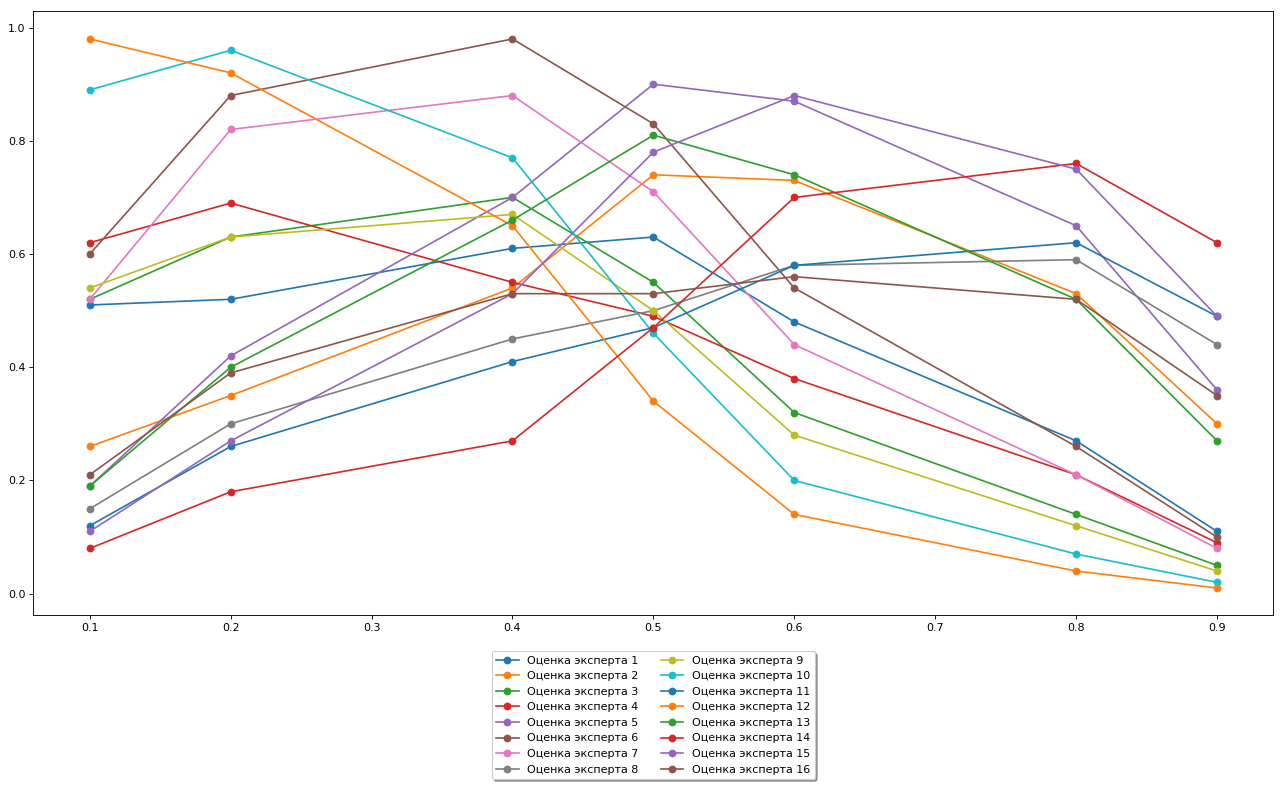

In [92]:
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
for i in range(experts):
    plt.plot(x, v0[i], '-o', label = 'Оценка эксперта ' + str(i + 1))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

# ВЫВОД ИНТЕРВАЛЬНОЙ ОЦЕНКИ ДЛЯ ЭКСПЕРТОВ

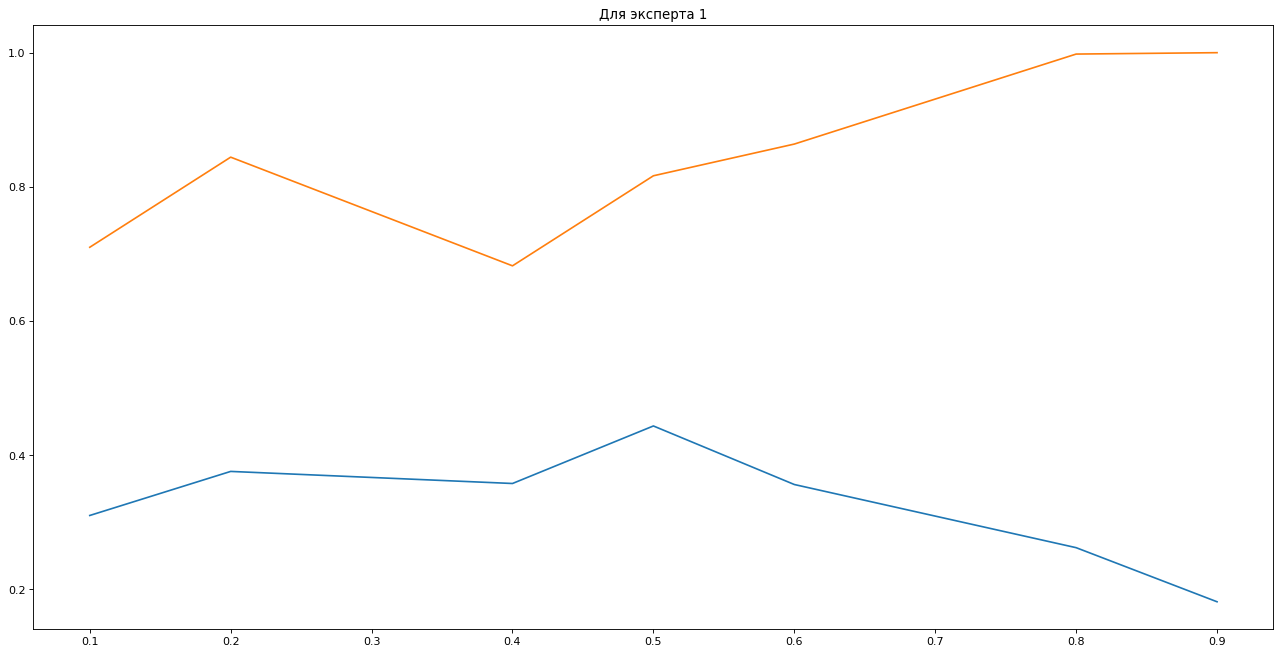

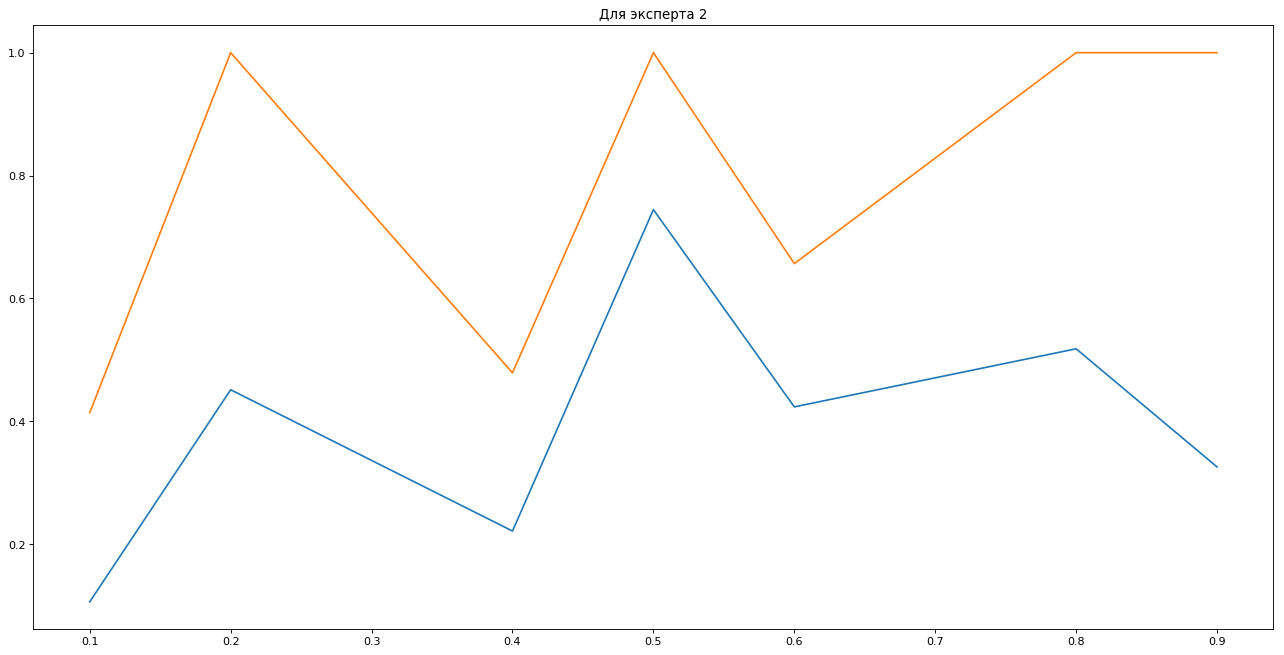

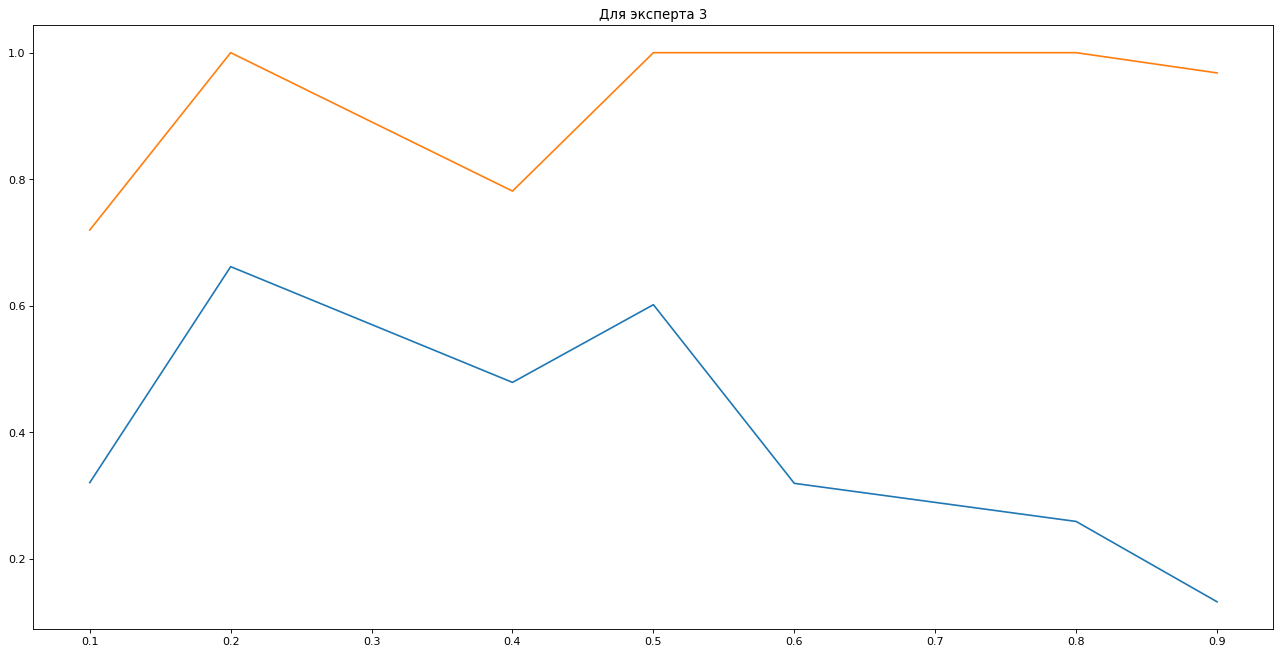

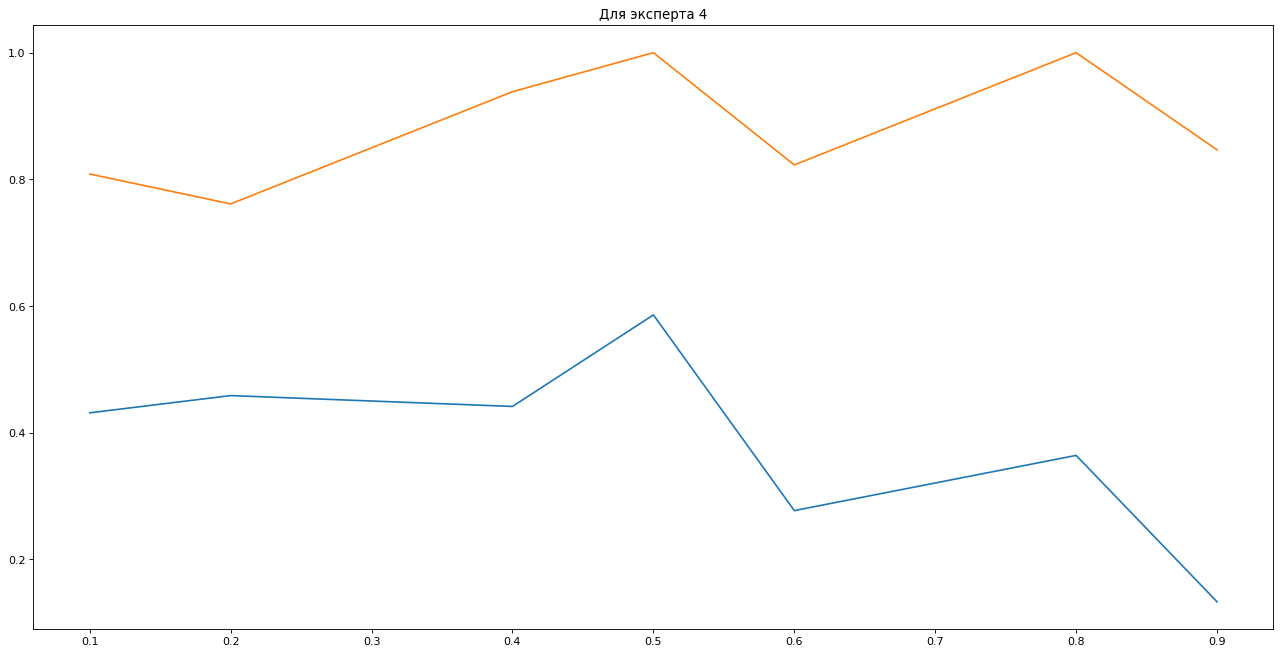

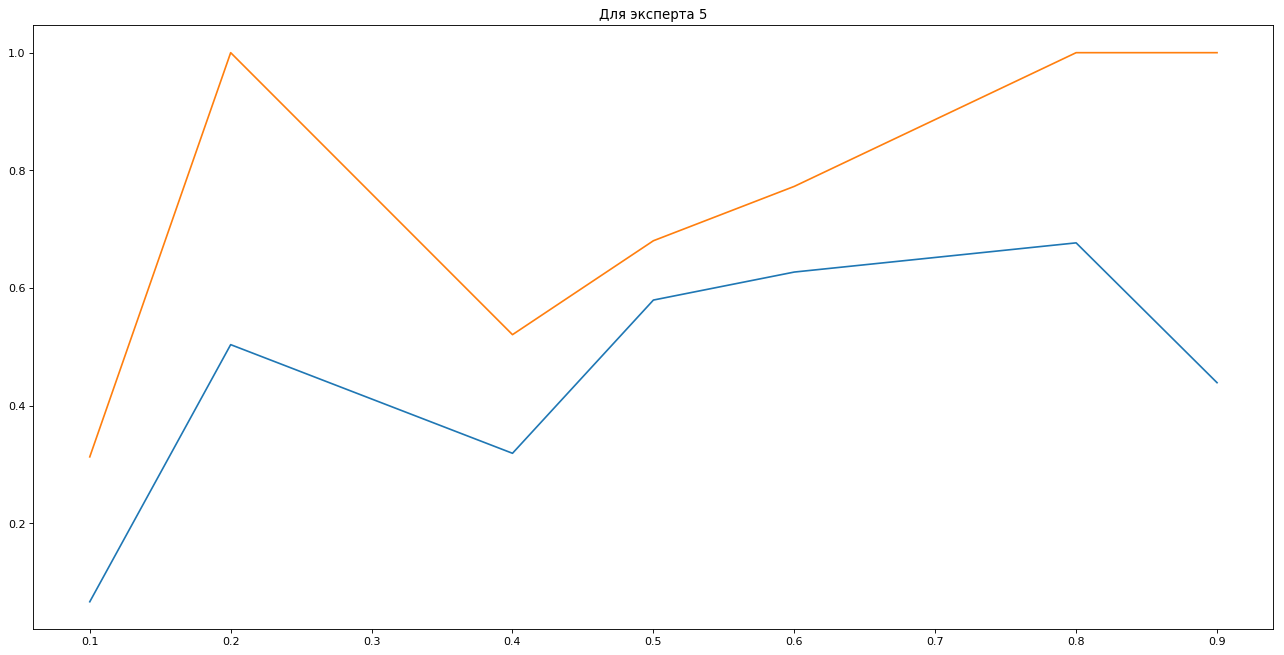

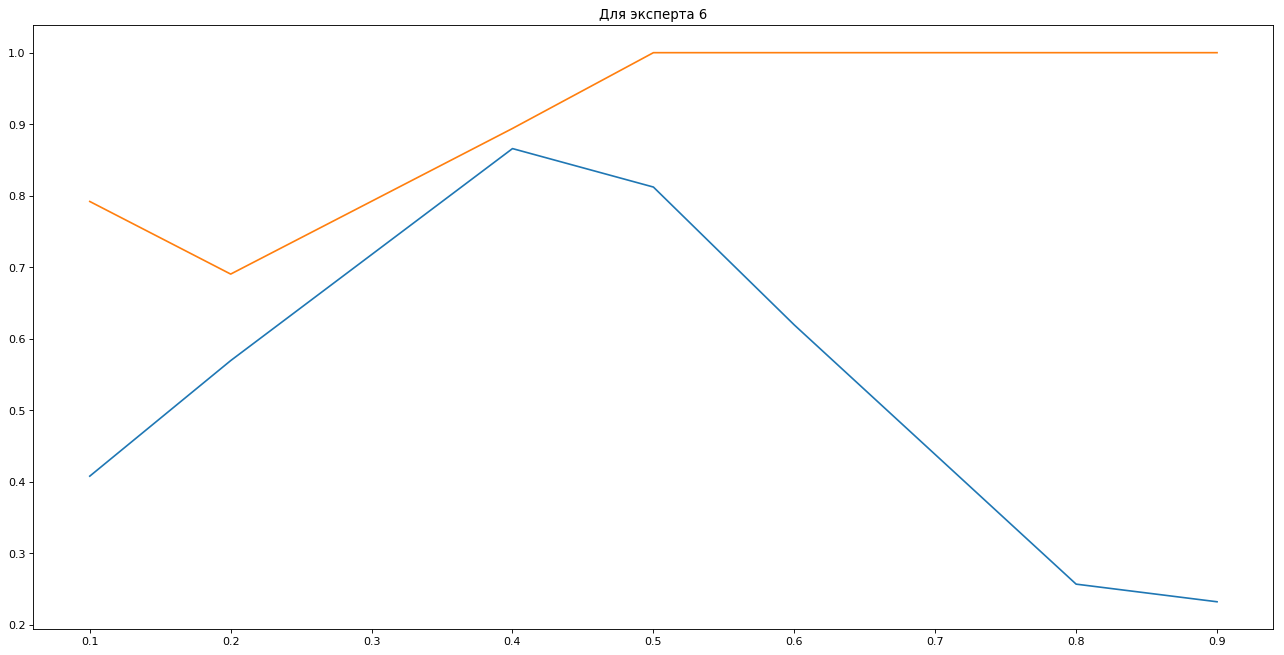

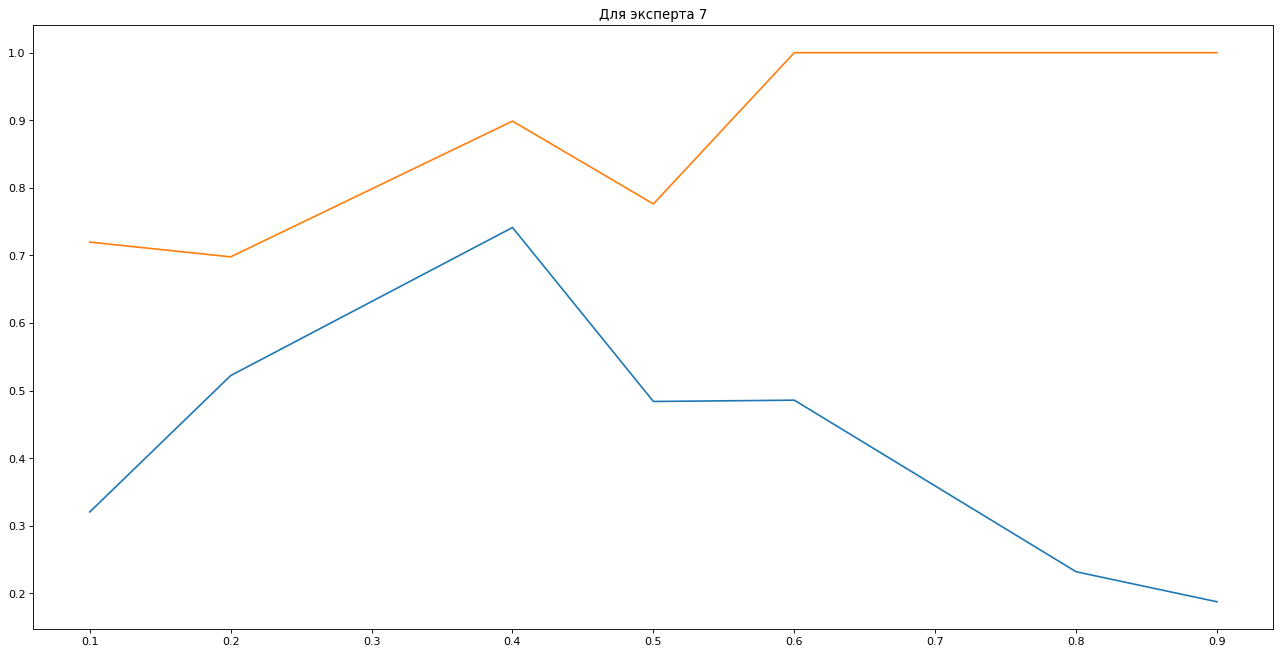

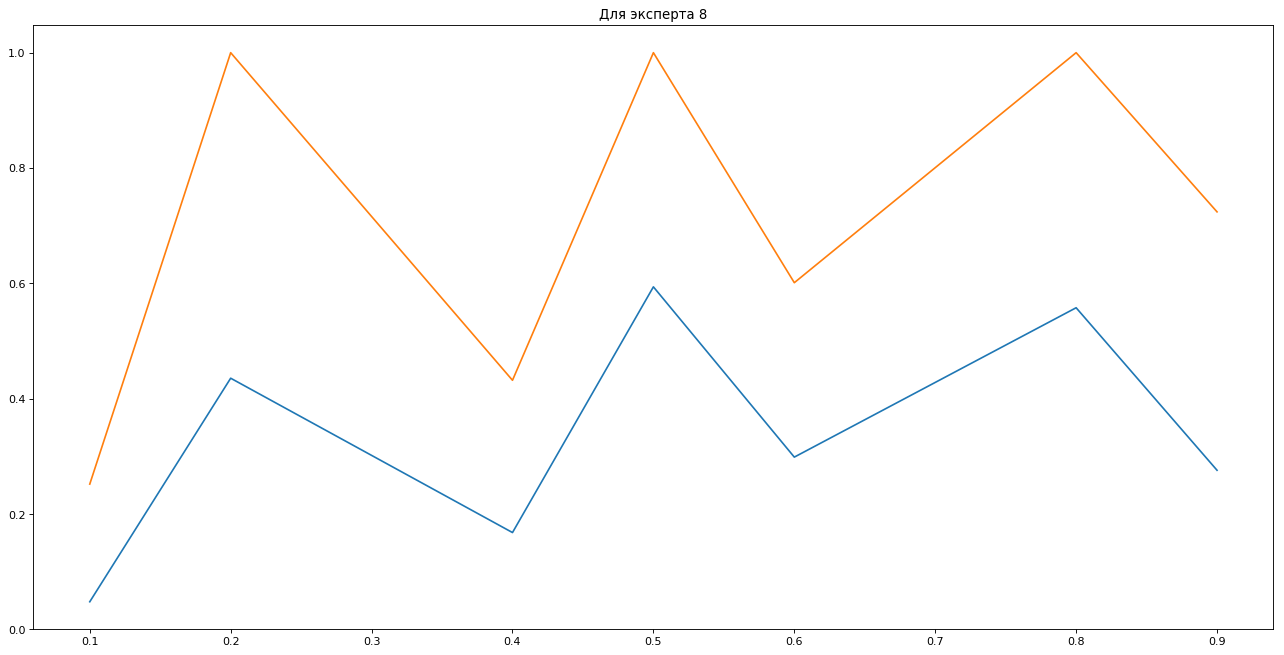

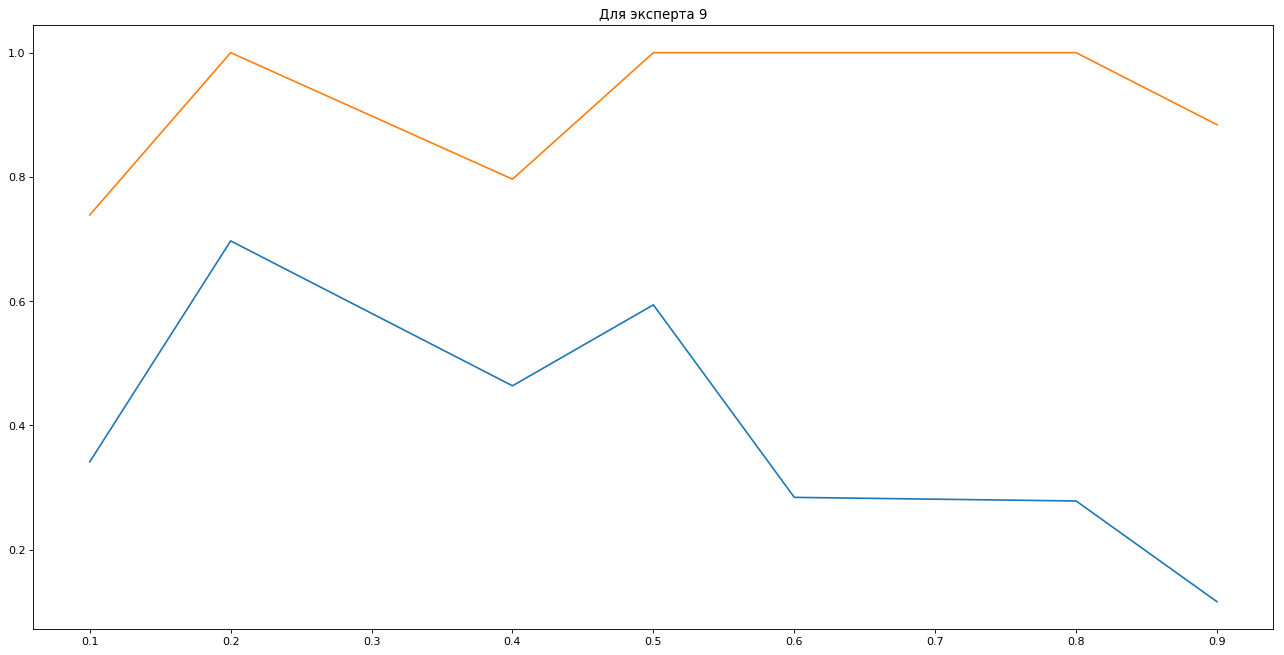

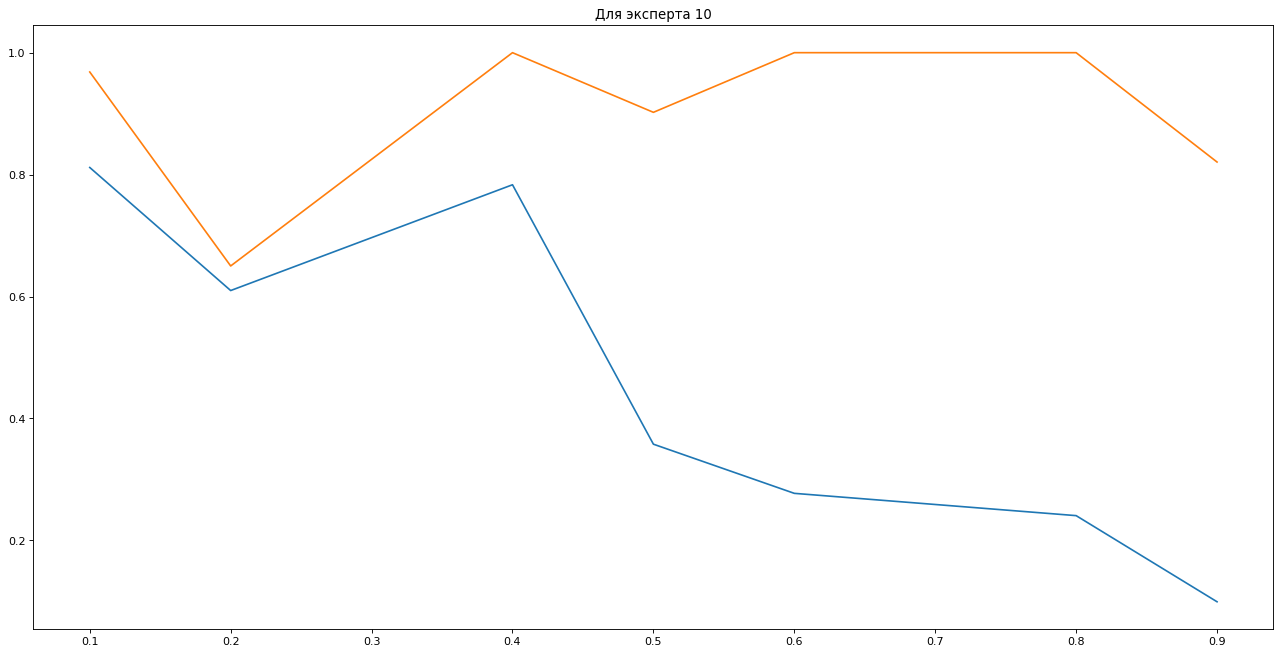

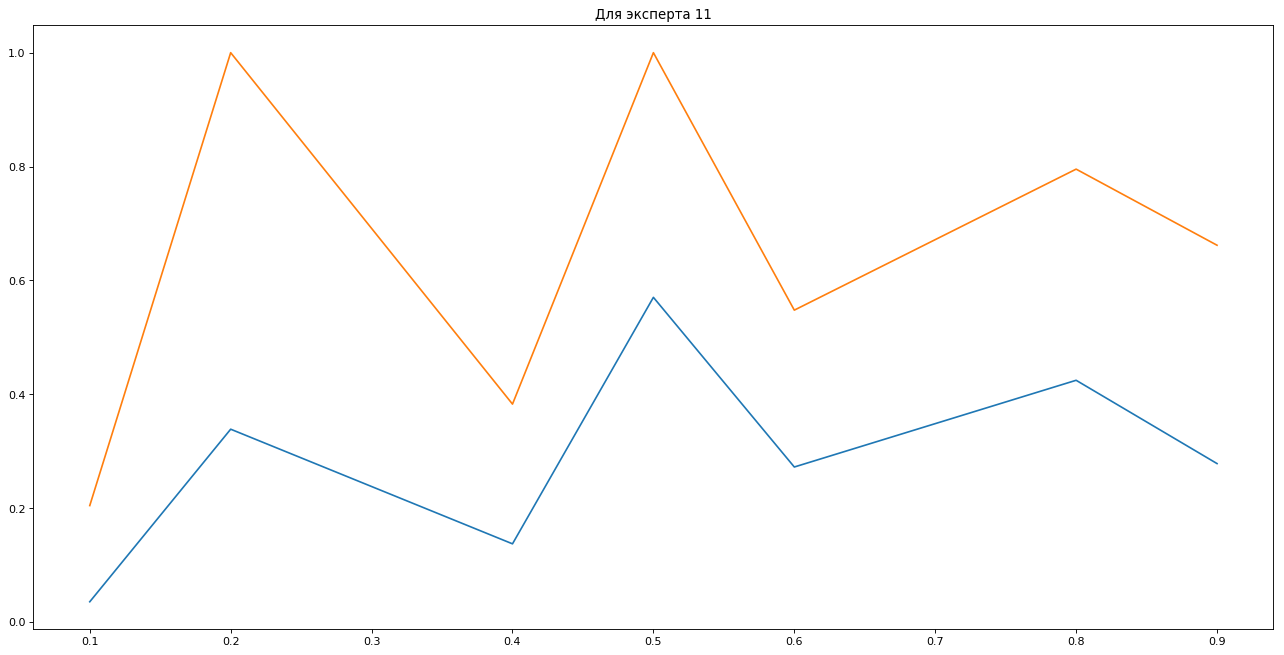

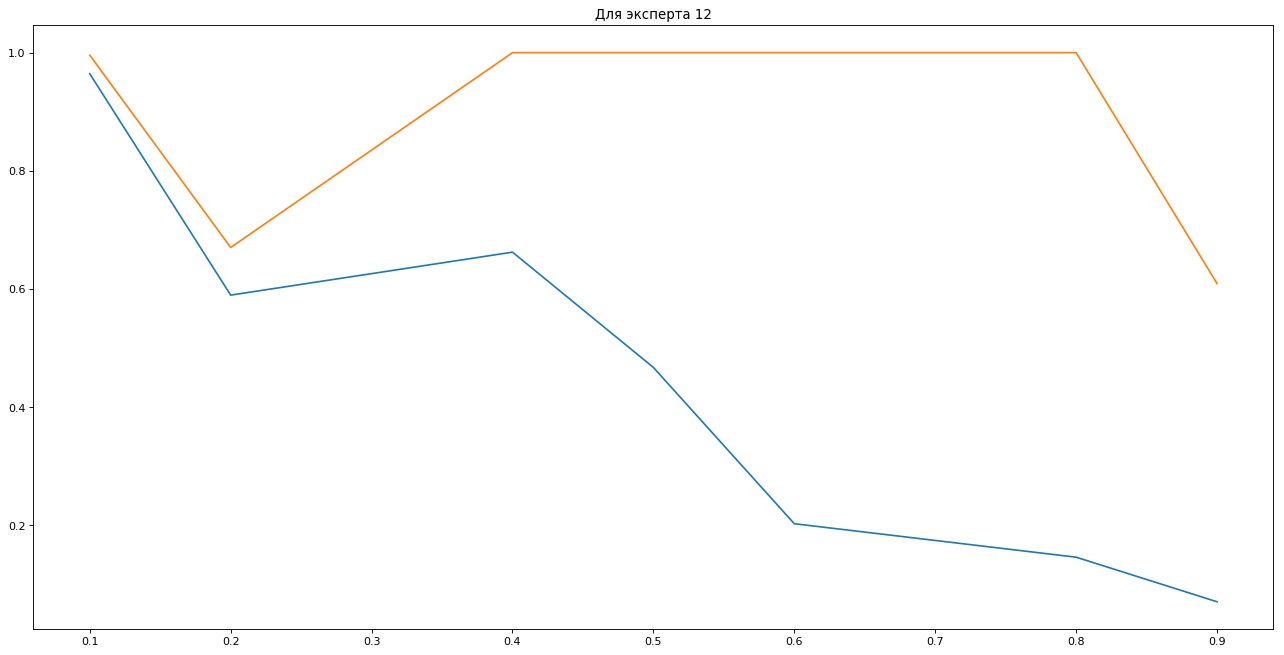

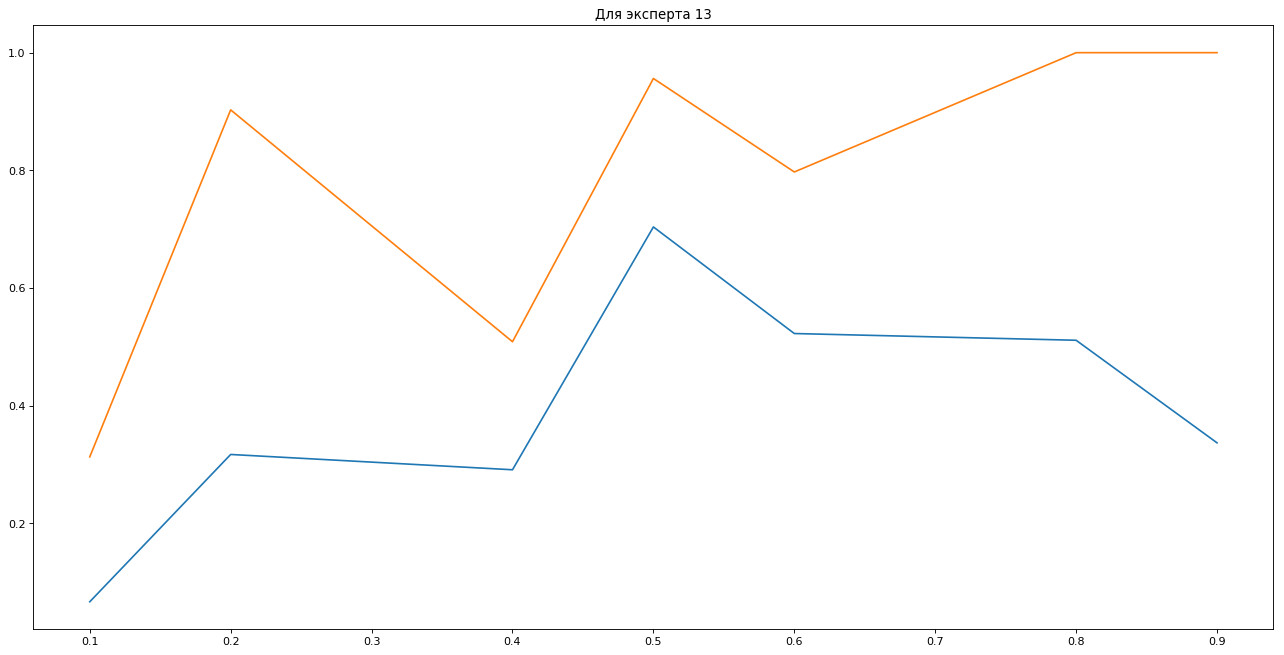

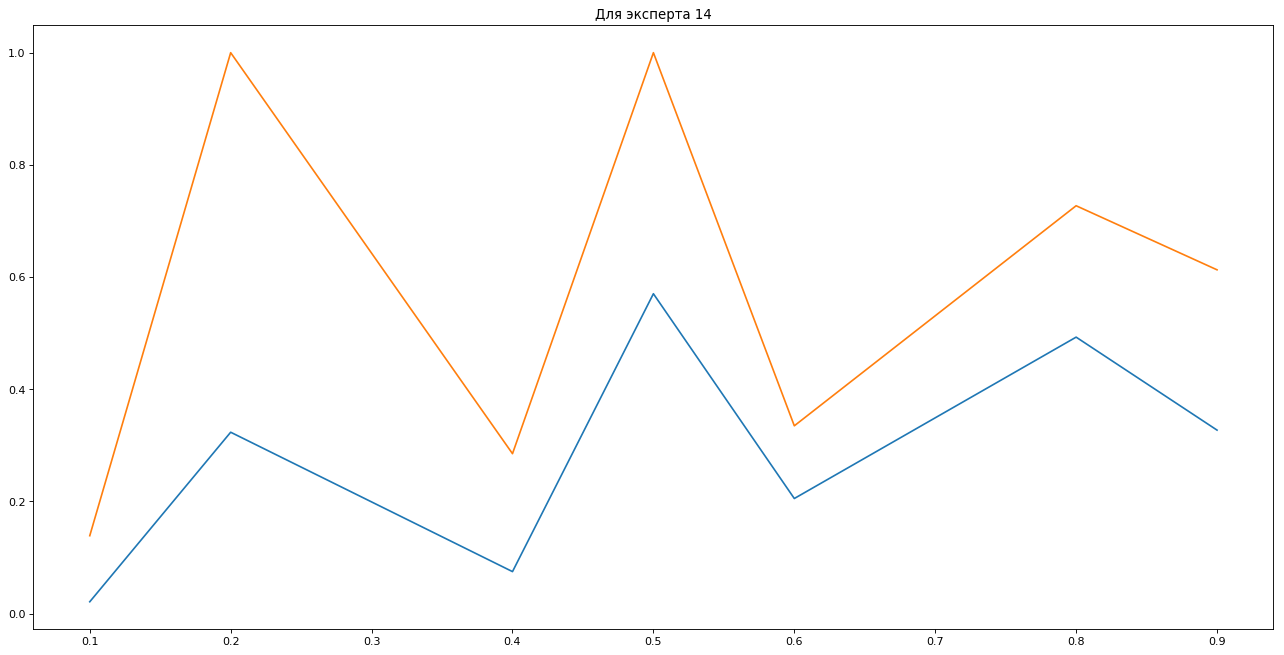

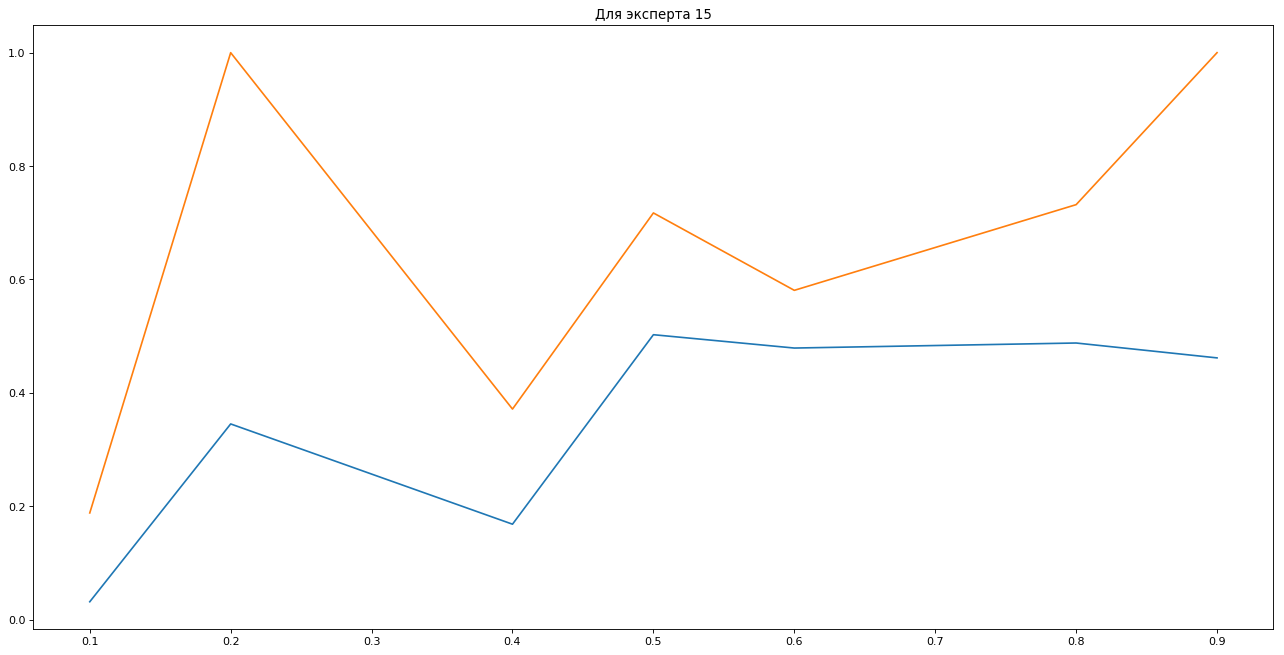

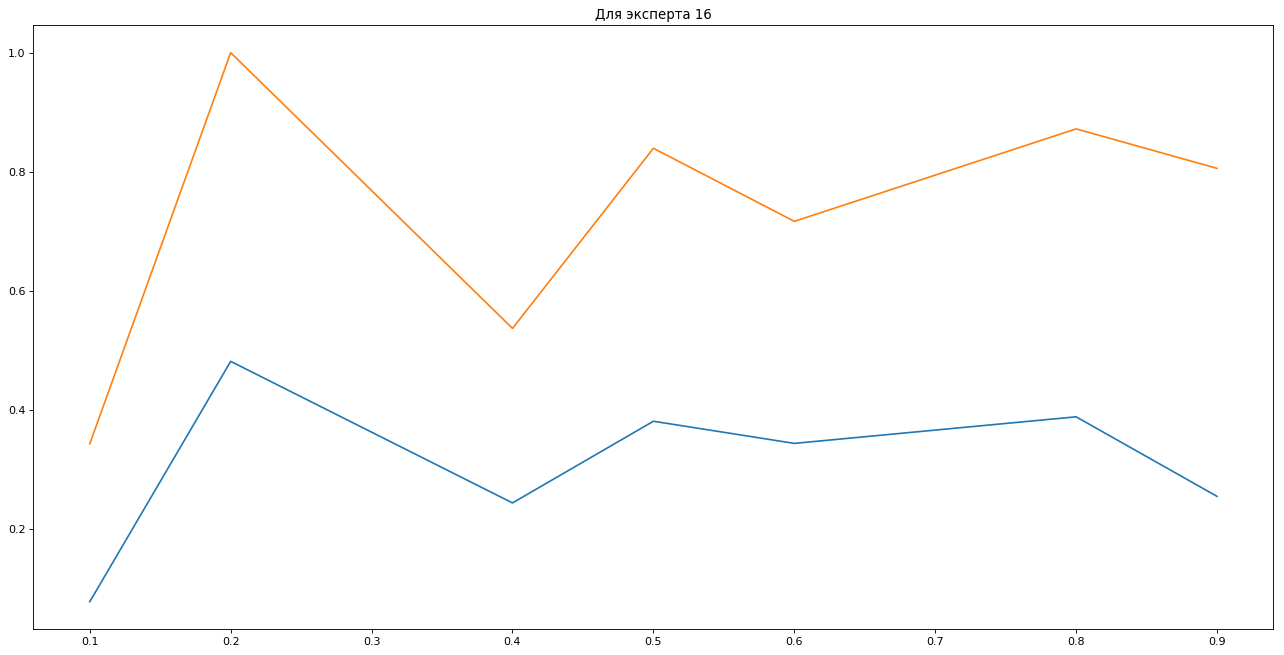

In [93]:
for i in range(experts):

    figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(x, d_niz0[i])
    plt.plot(x, d_verh0[i])
    plt.title('Для эксперта '+ str(i + 1))

# ВЫВОД СРЕДНЕ ИНТЕРВАЛЬНОЙ ОЦЕНКИ 

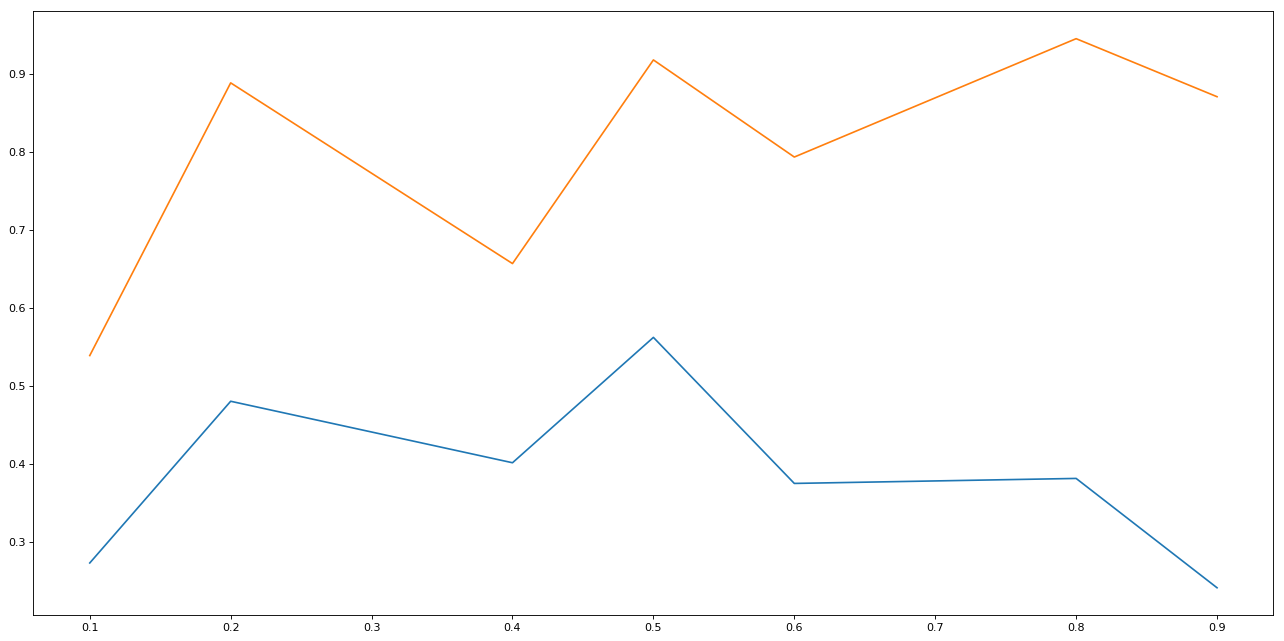

In [94]:
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x, aver_niz0)
plt.plot(x, aver_verh0)

# ВЫВОД ИНТЕРВАЛЬНО ИНТЕГРАЛЬНОЙ ОЦЕНКИ 

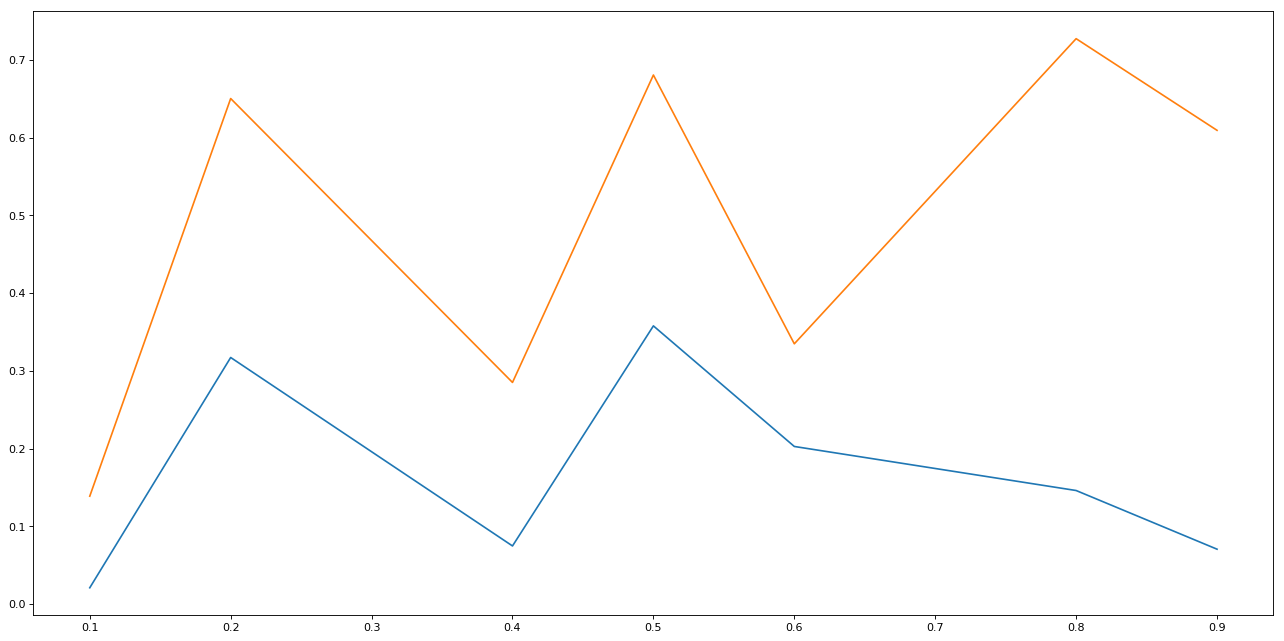

In [95]:
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x, inter_integ_niz0)
plt.plot(x, inter_integ_verh0)

# ВЫВОД ГАУССОВОЙ ОЦЕНКИ

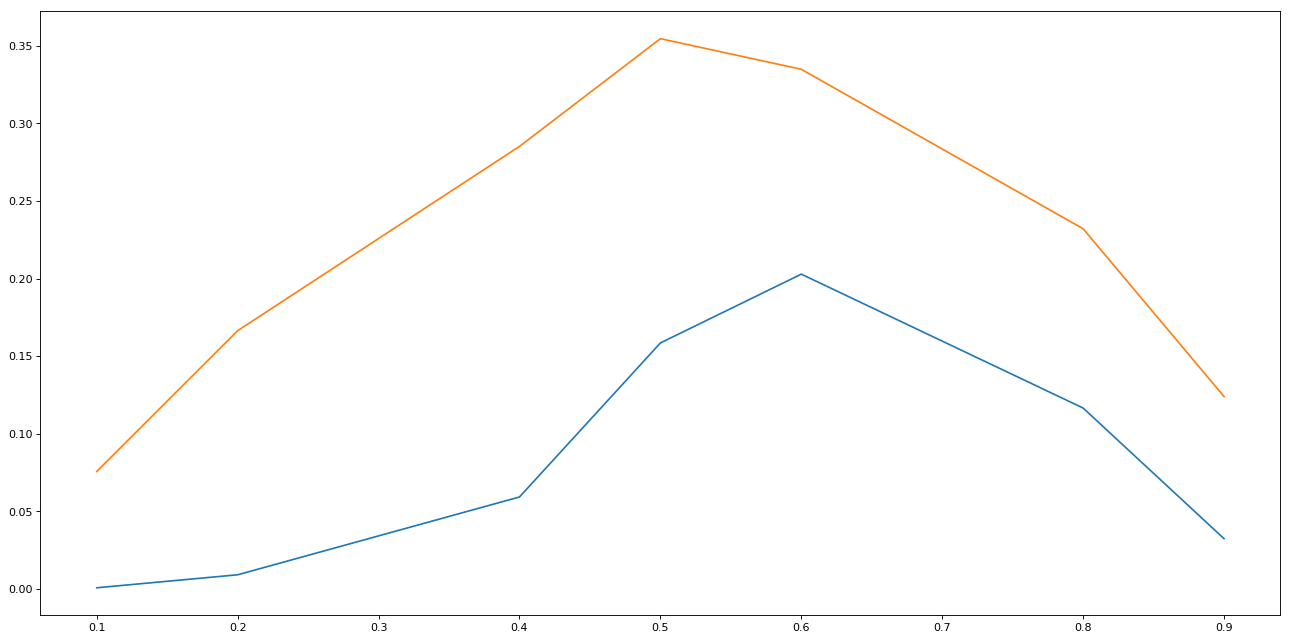

In [96]:
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x, gauss_niz0)
plt.plot(x, gauss_verh0)

# РАЗЛИЧНЫЕ ТИПЫ ОЦЕНОК ДЛЯ ЭКСПЕРТОВ

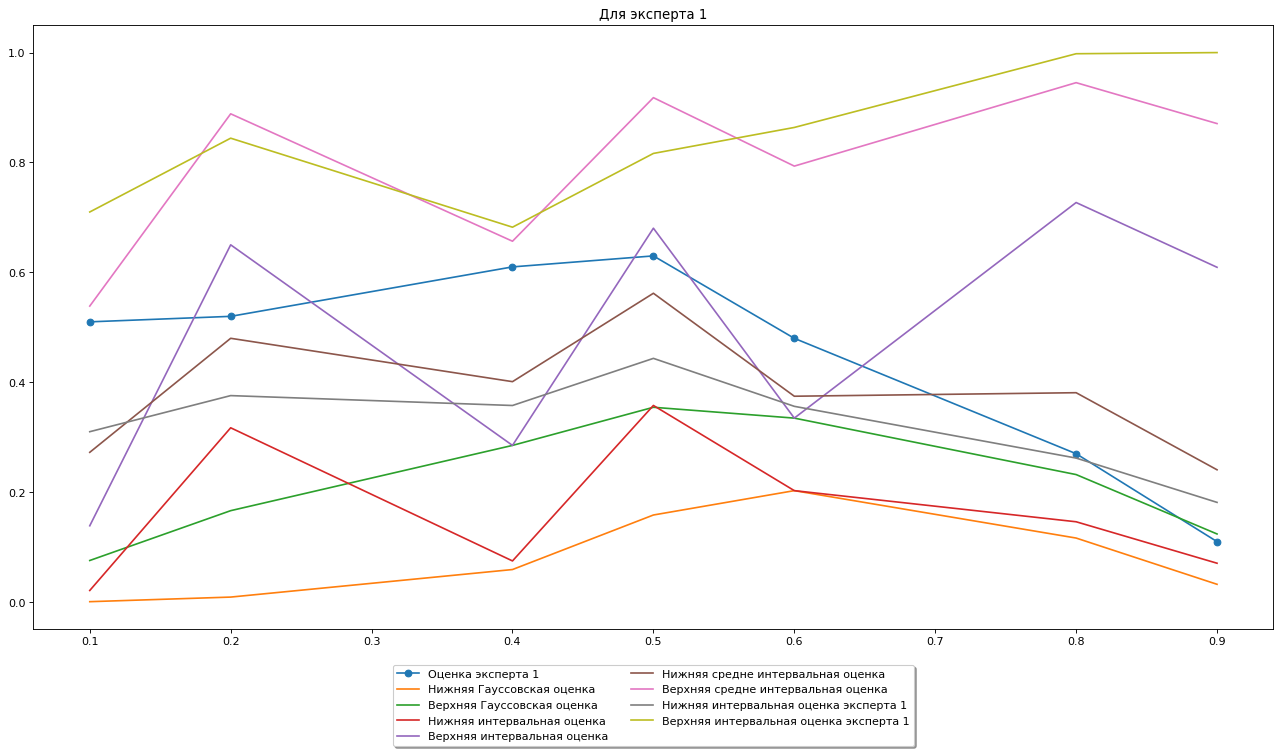

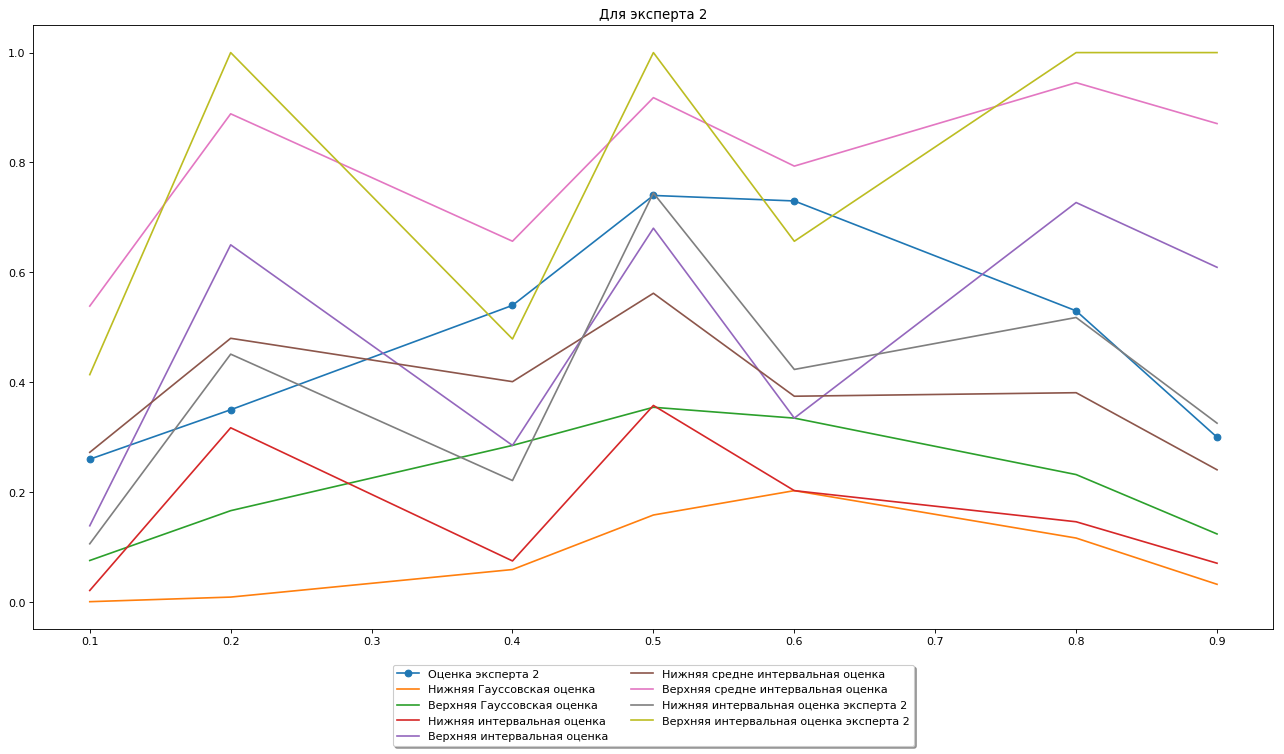

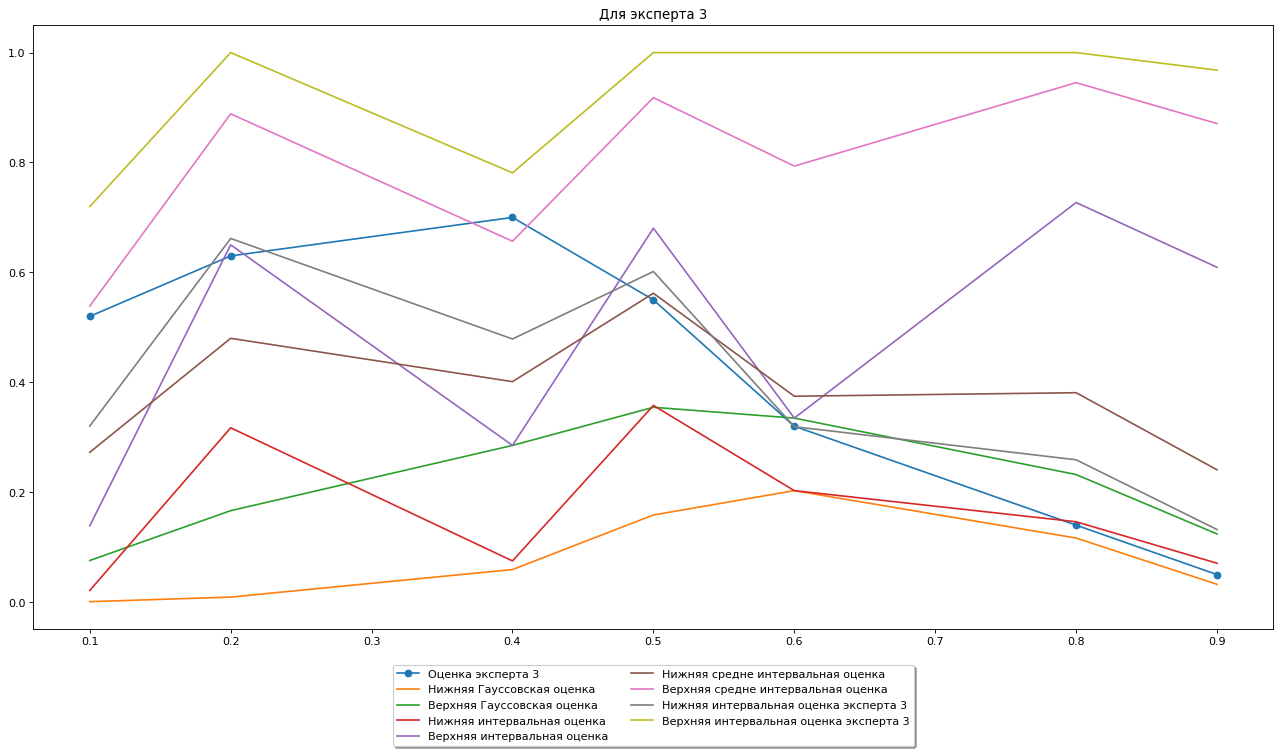

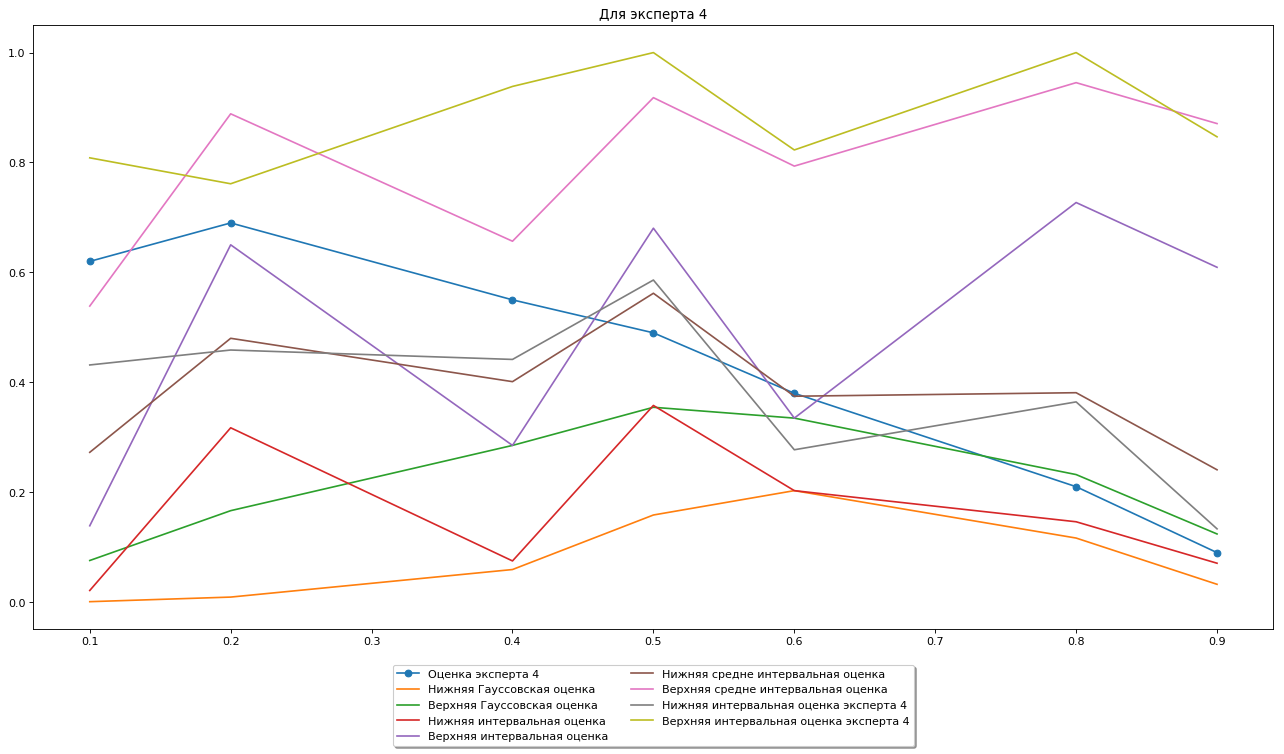

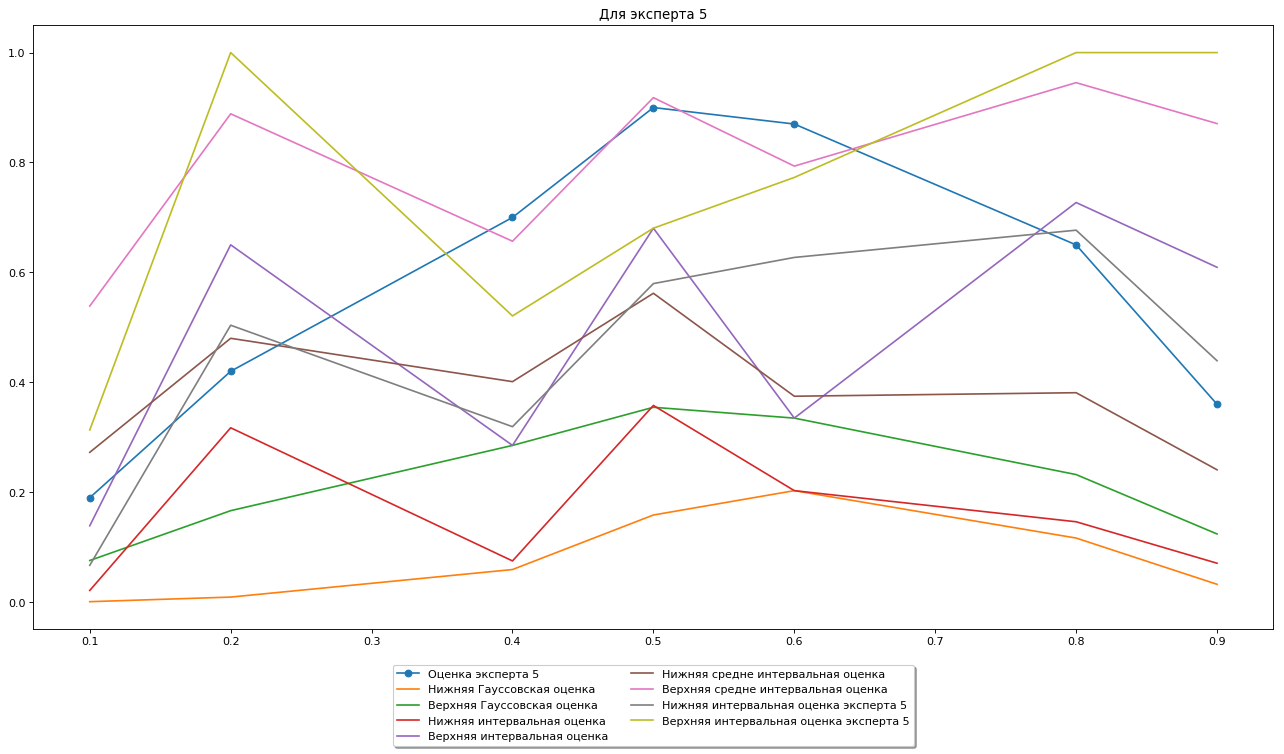

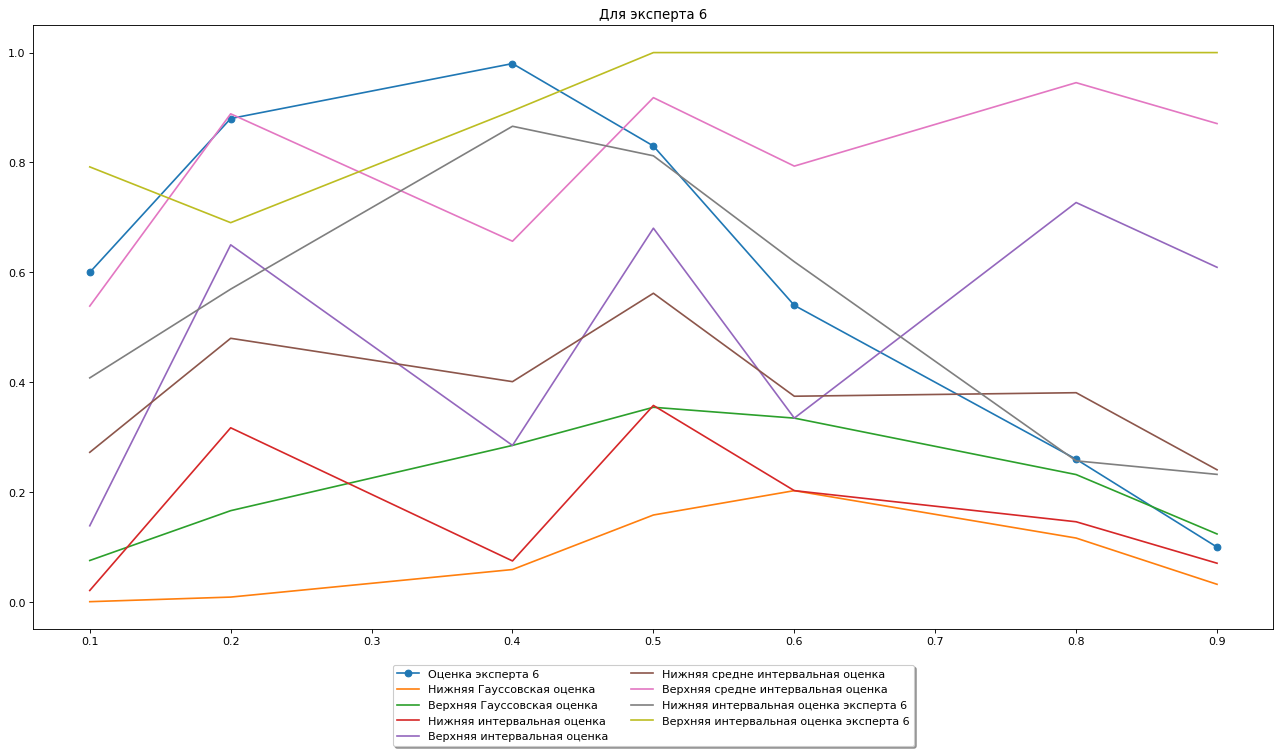

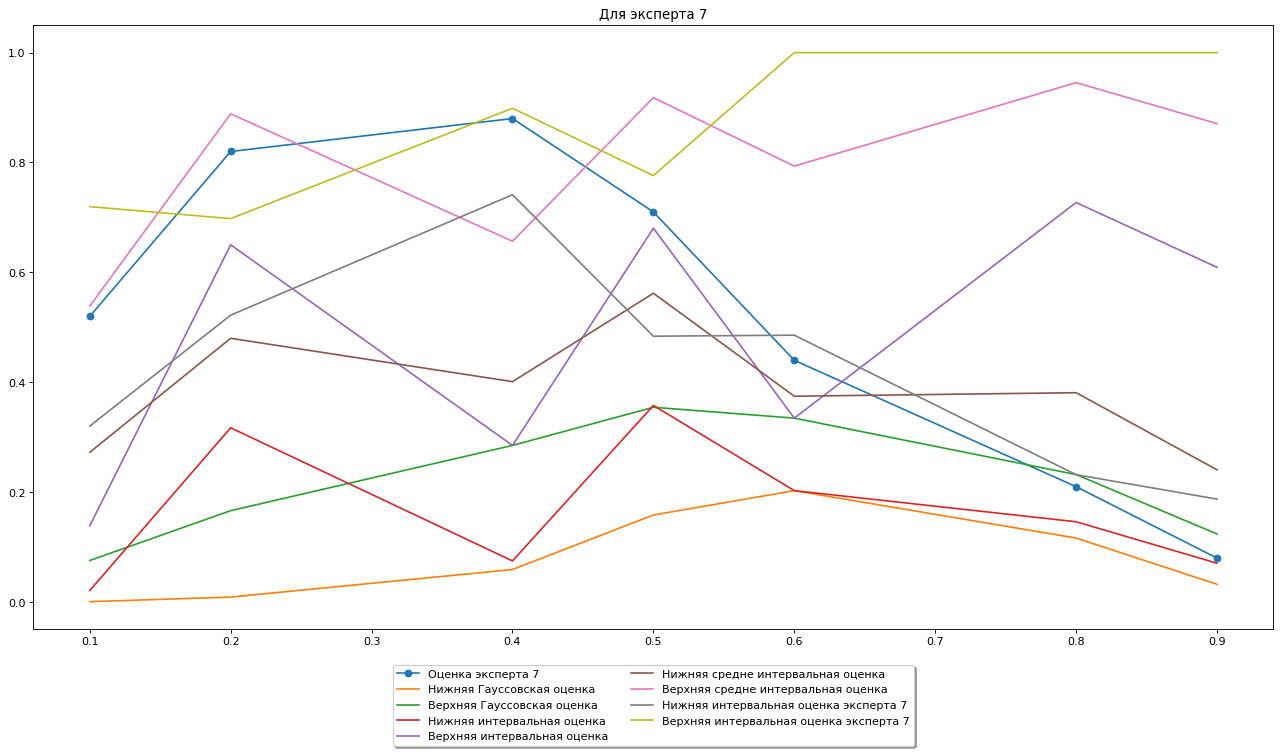

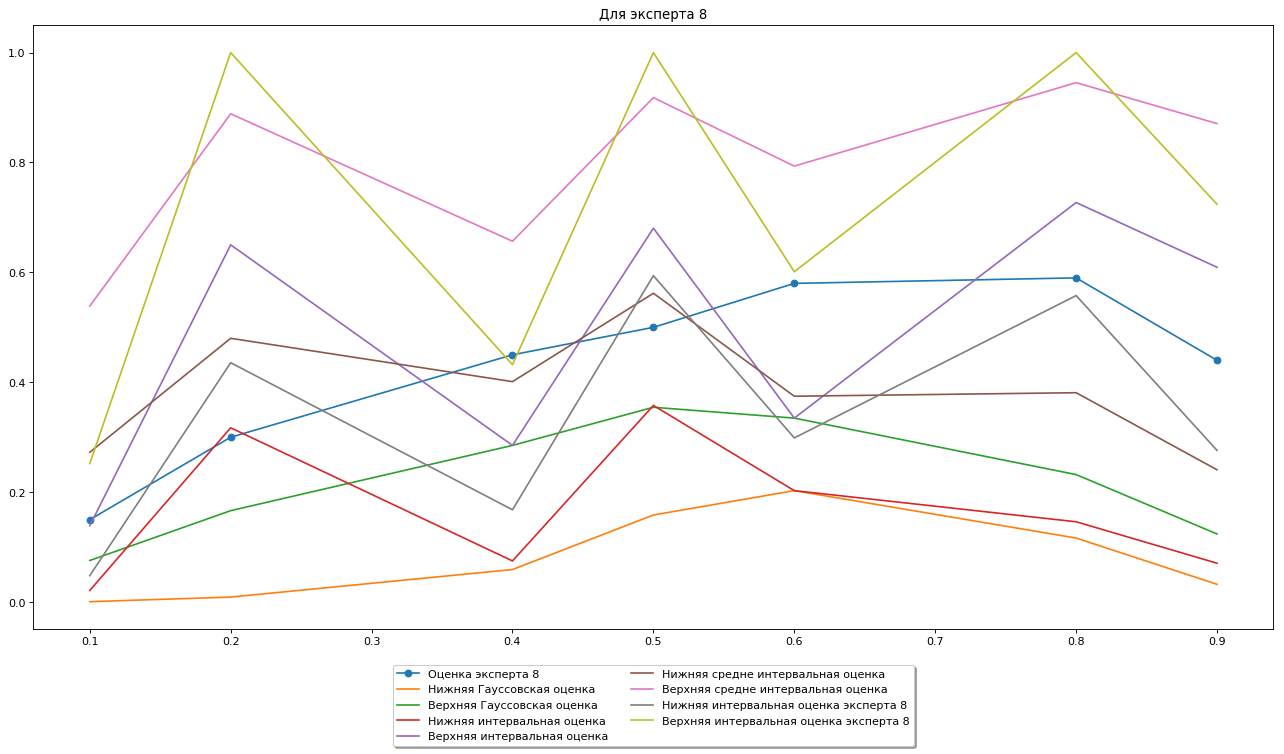

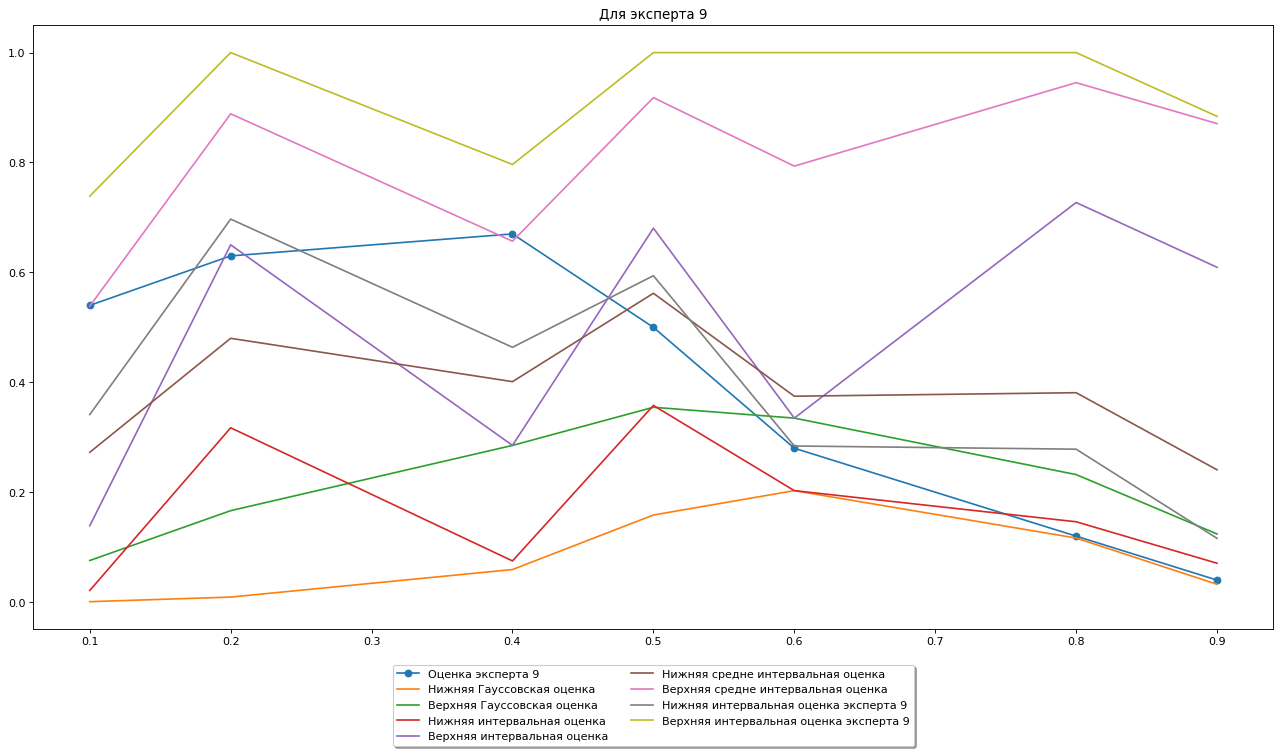

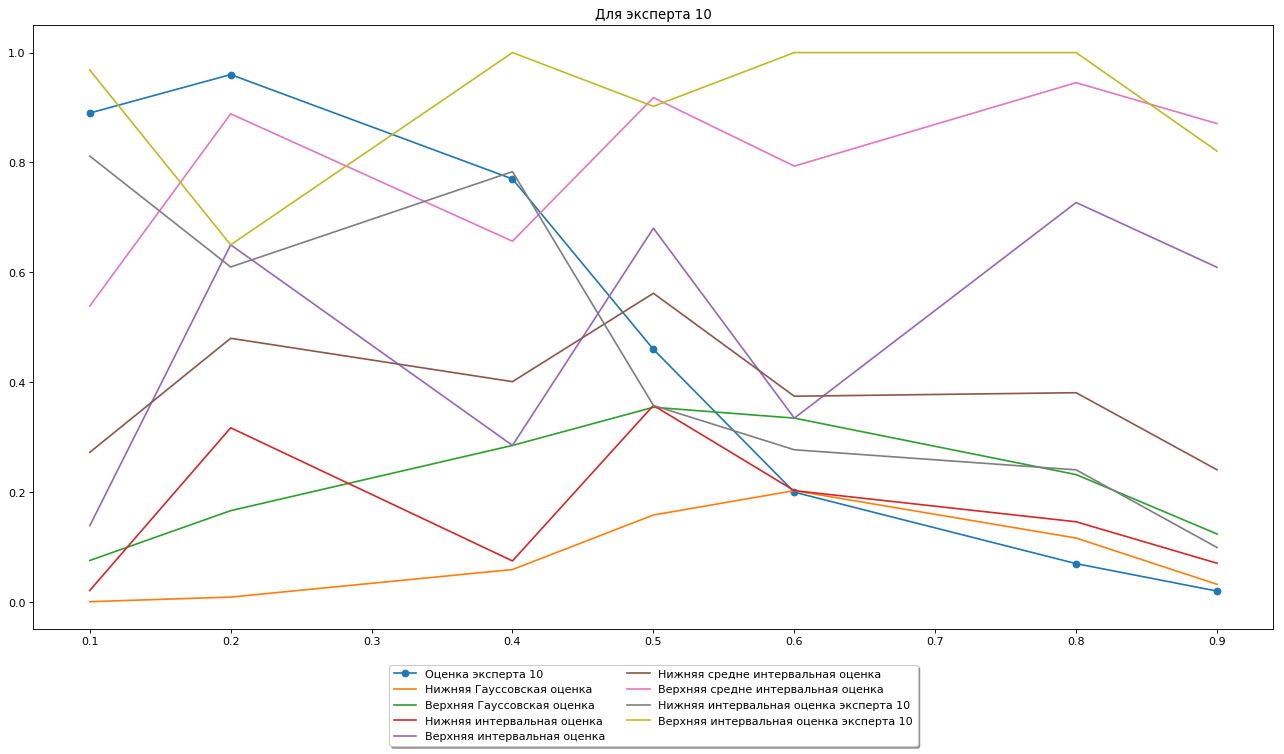

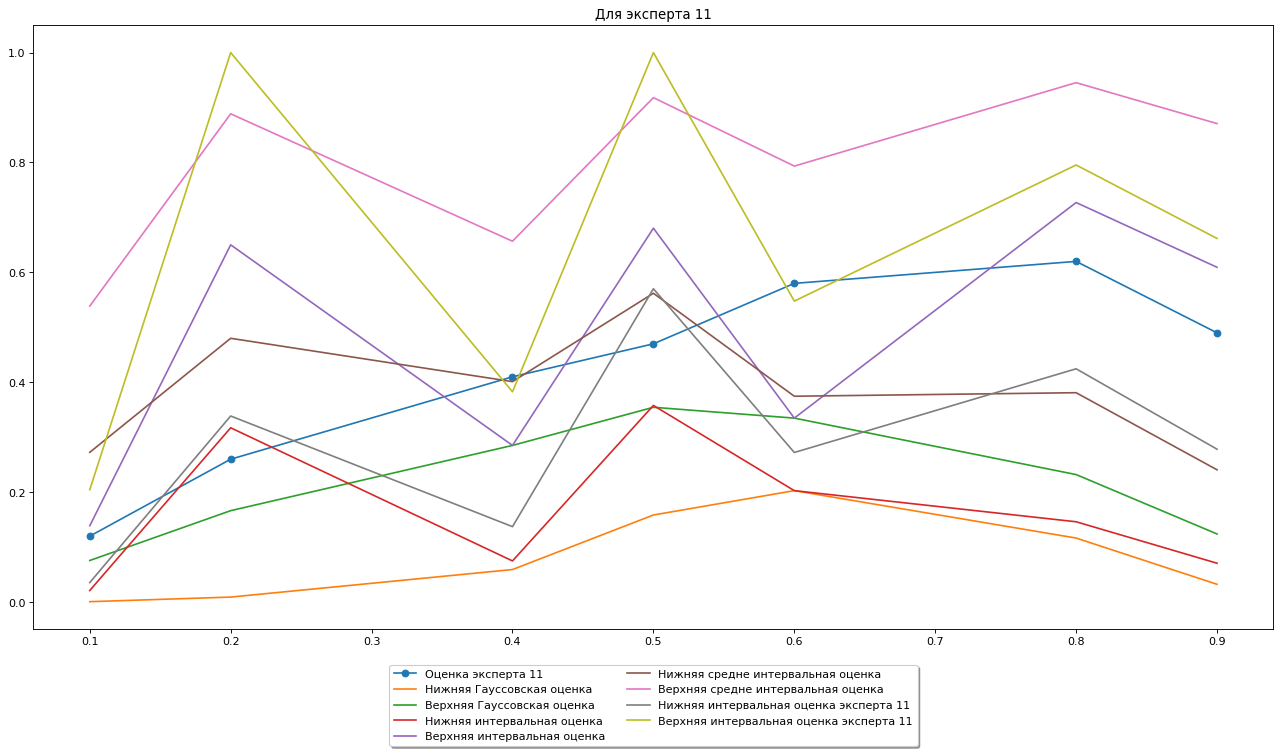

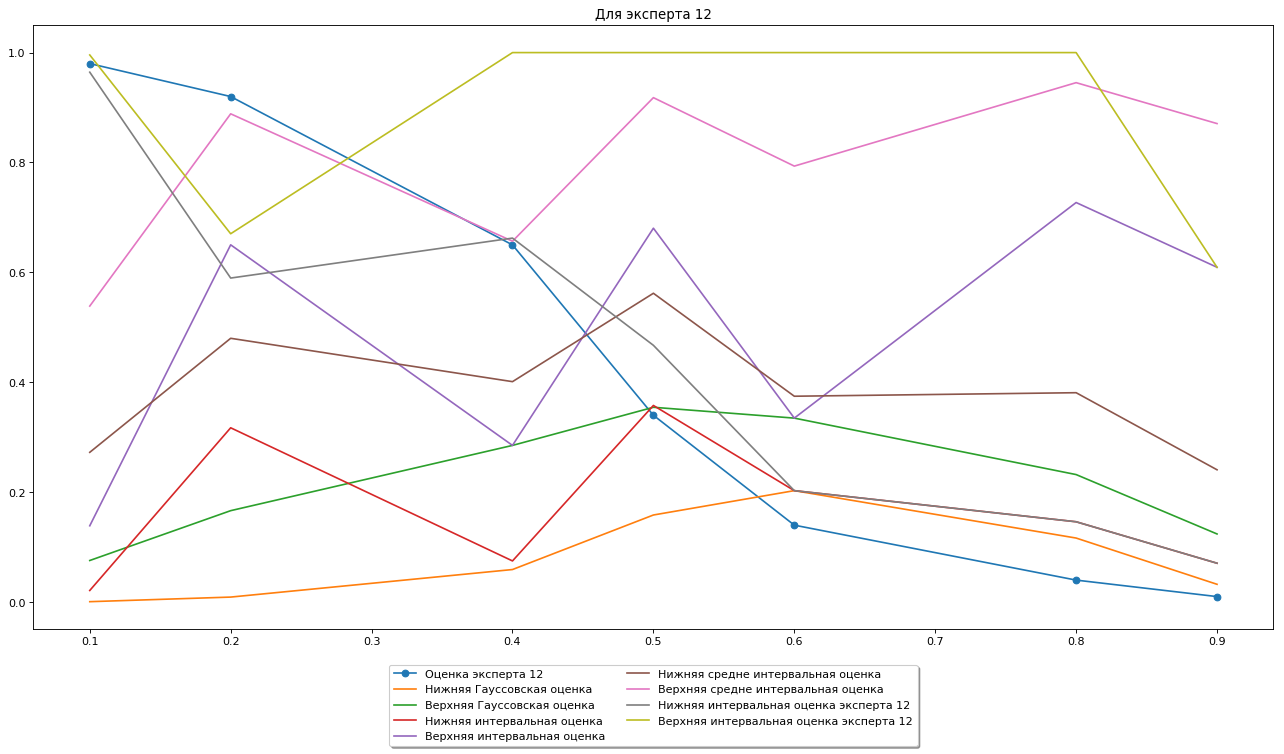

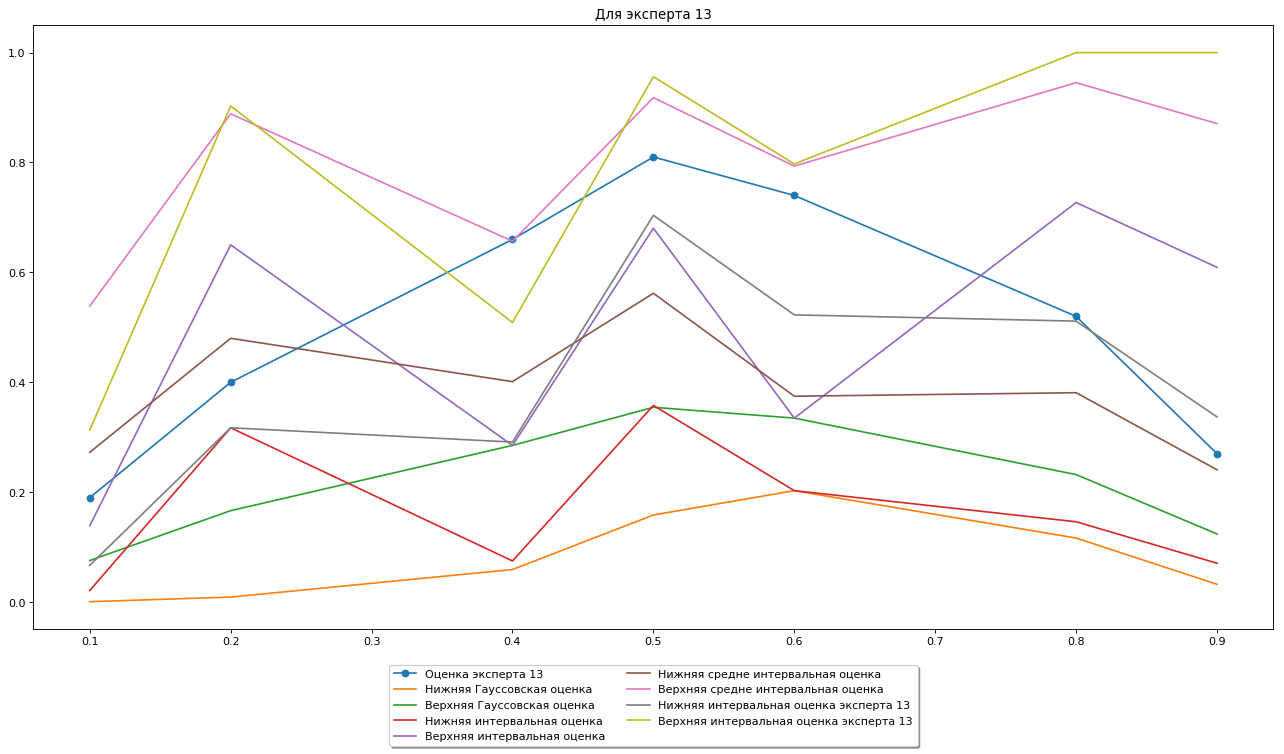

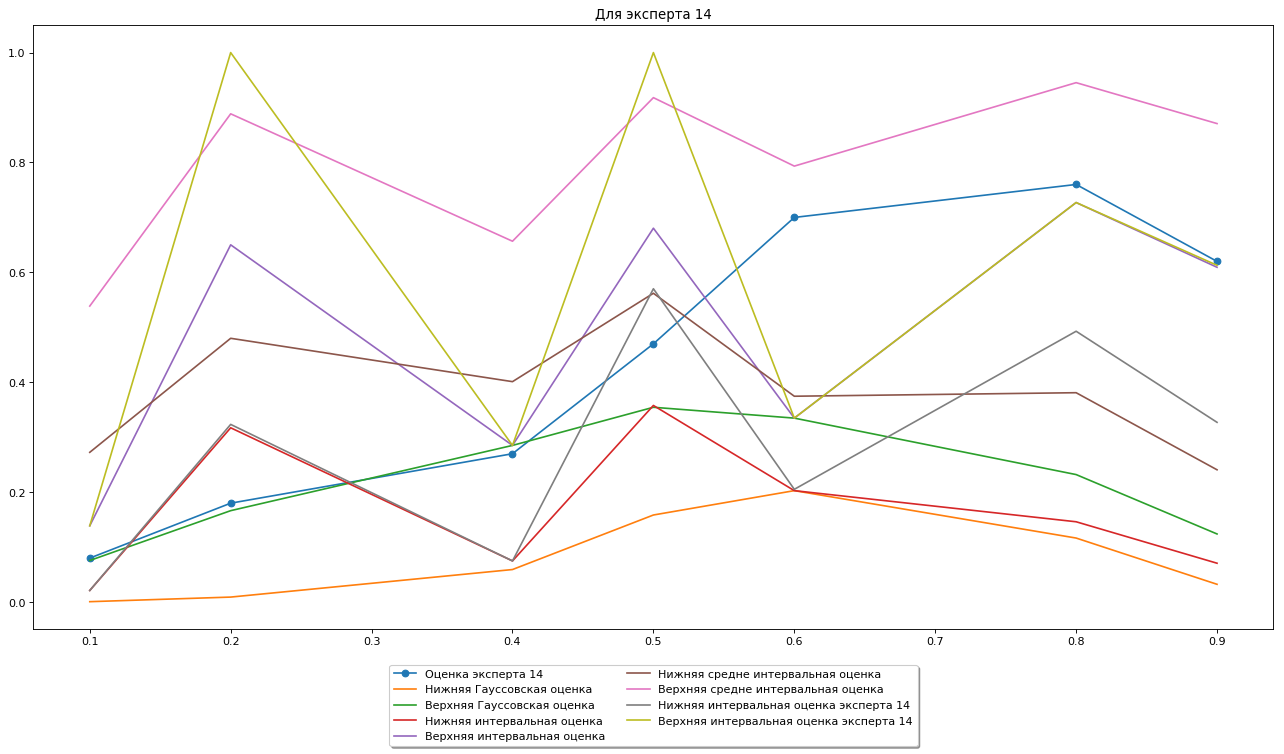

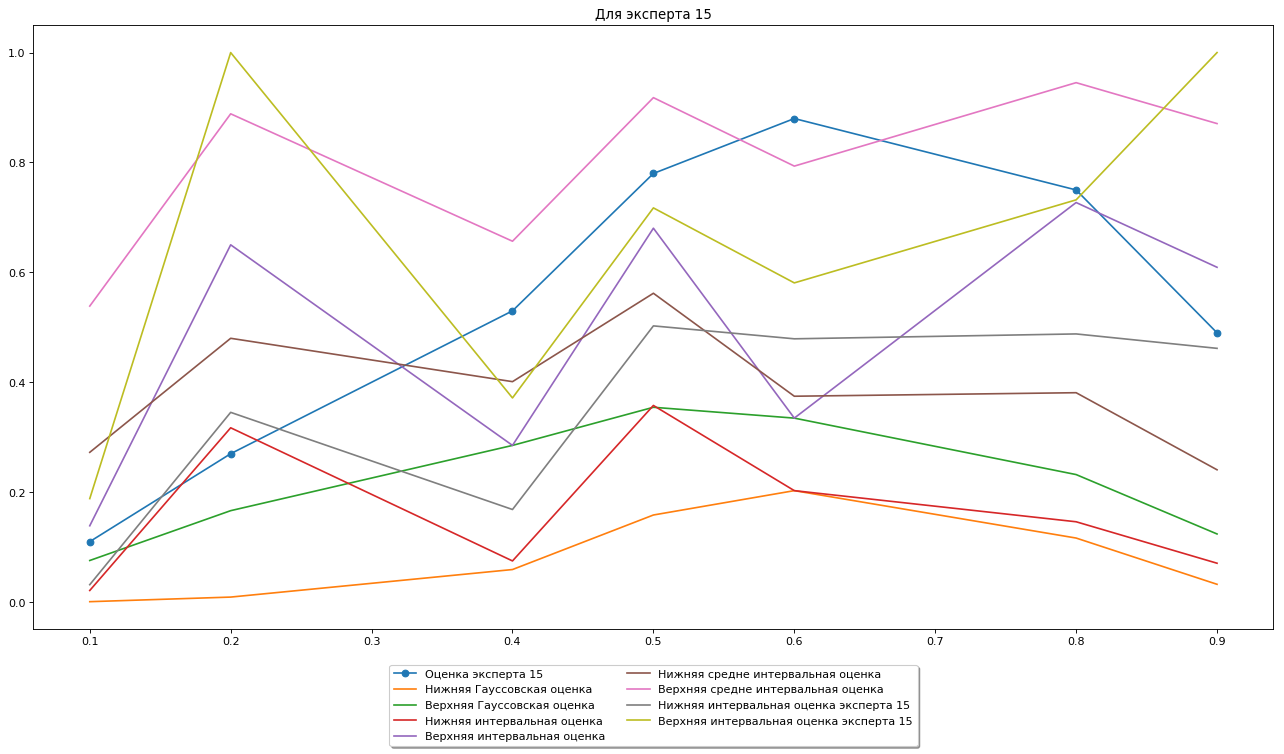

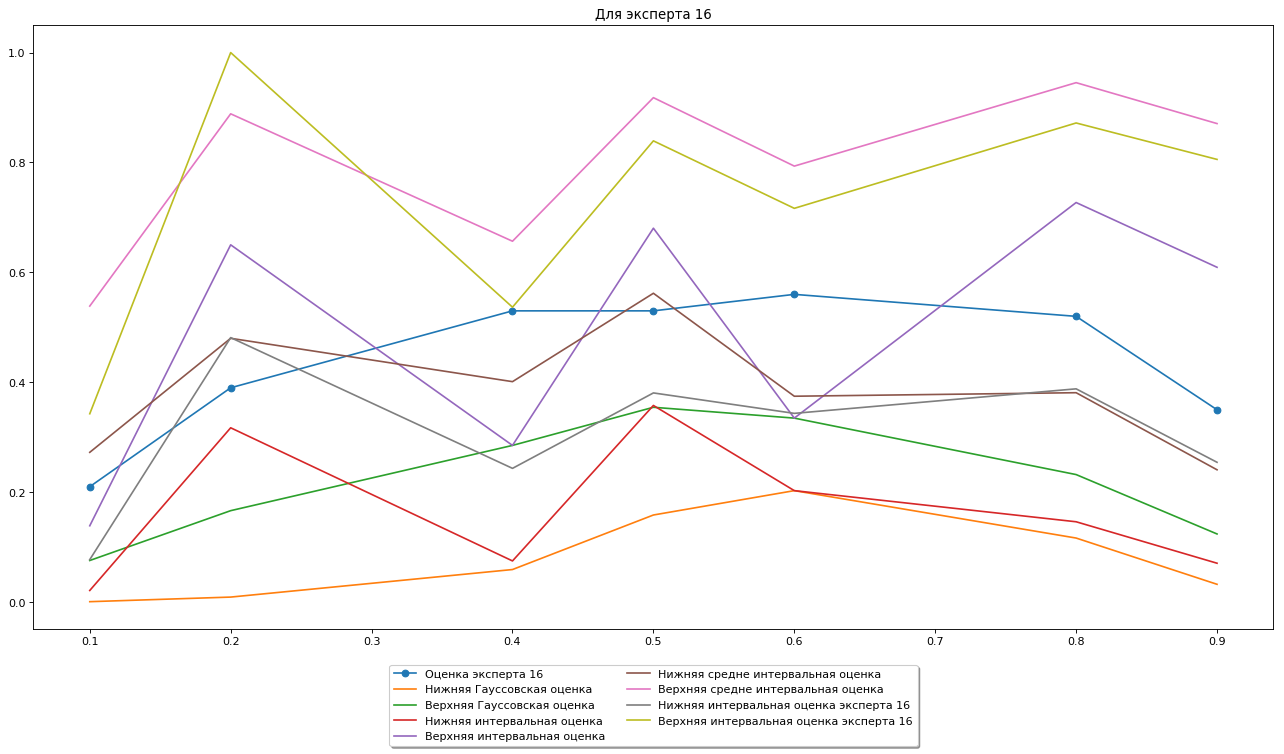

In [97]:

for i in range(experts):

    figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    

    plt.plot(x, v0[i], '-o', label = 'Оценка эксперта ' + str(i + 1))
    plt.plot(x, gauss_niz0, label = 'Нижняя Гауссовская оценка')
    plt.plot(x, gauss_verh0, label = 'Верхняя Гауссовская оценка')
    plt.plot(x, inter_integ_niz0, label = 'Нижняя интервальная оценка')
    plt.plot(x, inter_integ_verh0, label = 'Верхняя интервальная оценка')
    plt.plot(x, aver_niz0, label = 'Нижняя средне интервальная оценка')
    plt.plot(x, aver_verh0, label = 'Верхняя средне интервальная оценка')
    plt.plot(x, d_niz0[i], label = 'Нижняя интервальная оценка эксперта ' + str(i + 1))
    plt.plot(x, d_verh0[i], label = 'Верхняя интервальная оценка эксперта ' + str(i + 1))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
    plt.title('Для эксперта '+ str(i + 1))